# LAB 01 Ordinaria

Grupo A04

Lucía Casas, Marta Herraiz, Alba López y Paula Redondo

In [ ]:
# Librerías necesarias
from google.colab import files

import pandas as pd
import numpy as np
from numpy import linalg
import random

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from typing_extensions import dataclass_transform
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import warnings

from scipy.stats import lognorm
from scipy.stats import norm
from scipy.stats import beta

## Carga de los archivos de trabajo

A continuación, se cargan los datos contenidos en los archivos Excel y CSV sobre los que se va a trabajar en el presente documento.

In [ ]:
# Carga de los archivos al directorio de trabajo
uploaded = files.upload()

Saving ozone.csv to ozone.csv
Saving USA.xlsx to USA.xlsx
Saving vacunaciones.csv to vacunaciones.csv


## Práctica 1: Vacunación Covid


En primer lugar vamos a cargar el conjunto de datos con el que vamos a trabajar

In [ ]:
# Cargar el conjunto de datos
df = pd.read_csv("vacunaciones.csv")

# Nos aseguramos de que el DataFrame esté ordenado por país y fecha
df.sort_values(by=['country', 'date'], inplace=True)

A continuación se obtiene una vista previa rápida de los datos para comprender la estructura y el contenido del DataFrame. De esta forma nos aseguramos de que los datos se hayan cargado y procesado correctamente.

In [ ]:
df.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Albania,ALB,2021-01-10,0.0,0.0,NaN,NaN,NaN,0.00,0.00,NaN,NaN,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/vaksinimi-anticovid...
1,Albania,ALB,2021-01-11,NaN,NaN,NaN,NaN,64.0,NaN,NaN,NaN,22.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/vaksinimi-anticovid...
2,Albania,ALB,2021-01-12,128.0,128.0,NaN,NaN,64.0,0.00,0.00,NaN,22.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/vaksinimi-anticovid...
3,Albania,ALB,2021-01-13,188.0,188.0,NaN,60.0,63.0,0.01,0.01,NaN,22.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/vaksinimi-anticovid...
4,Albania,ALB,2021-01-14,266.0,266.0,NaN,78.0,66.0,0.01,0.01,NaN,23.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/vaksinimi-anticovid...


La base de datos con la que vamos a trabajar contiene la siguiente información:
* Country: el país para el que se facilita la información sobre la vacunación.
* Country ISO Code - código del país.
* Date - fecha de la entrada de datos; para algunas de las fechas tenemos sólo las vacunaciones diarias, para otras, sólo el total (acumulativo);
* Total number of vaccinations - es el número absoluto de vacunaciones totales en el país;
* Total number of people vaccinated - se refiere al número total de personas vacunadas. Una persona, dependiendo del esquema de inmunización, recibirá una o más vacunas (normalmente 2); en un momento dado, el número de vacunaciones podría ser mayor que el número de personas;
* Total number of people fully vaccinated - es el número de personas que recibieron todo el conjunto de vacunas según el esquema de vacunación (normalmente 2); en un momento determinado, puede haber un cierto número de personas que recibieron una vacuna y otro número (menor) de personas que recibieron todas las vacunas del esquema;
* Daily vaccinations (raw) - para una determinada entrada de datos, el número de vacunaciones para esa fecha/país;
* Daily vaccinations - para una determinada entrada de datos, el número de vacunaciones para esa fecha/país;
* Total vaccinations per hundred - relación (en porcentaje) entre el número de vacunaciones y la población total hasta la fecha en el país;
* Total number of people vaccinated per hundred - relación (en porcentaje) entre la población vacunada y la población total hasta la fecha en el país;
* Total number of people fully vaccinated per hundred - relación (en porcentaje) entre la población totalmente vacunada y la población total hasta la fecha en el país;
* Number of vaccinations per day - número de vacunaciones diarias para ese día y país;
* Daily vaccinations per million - relación entre el número de vacunaciones y la población total para la fecha actual en el país;
* Vaccines used in the country - nombres de vacunas utilizadas en el país (hasta la fecha);
* Source name - fuente de la información (autoridad nacional, organización internacional, organización local, etc.);
* Source website - sitio web de la fuente de información;

Lo primero será evitar los “missing values” de la columna “people vaccinated”. Para ello vamos a ver cuantos registros faltan en total.

In [ ]:
# Contar los valores faltantes en la columna 'People_Vaccinated'
missing_values_people_vaccinated = df['people_vaccinated'].isnull().sum()

# Imprimir el número de valores faltantes en la columna 'People_Vaccinated'
print(f'Valores faltantes en "People_Vaccinated": {missing_values_people_vaccinated}')

Valores faltantes en "People_Vaccinated": 1481


**1.- Lo primero será evitar los “missing values” de la columna “people vaccinated”. Para ello cogeremos los valores de los 3 días anteriores (si existen, en caso contrario dos o uno) y su media para rellenar dicha celda.**

La estrategia del enunciado nos dice que para eliminar los NaN debemos coger los valores de los 3 días anteriores (si existen, en caso contrario dos o uno) y su media para rellenar dicha celda.
El enunciado no dice nada sobre los casos en los que no haya información con la que hacer la media, por lo que en esas situaciones se rellenará el valor de los registros NaN con 0.

In [ ]:
# Crear una copia de los datos originales para evitar modificar el archivo original
datos_modificados = df.copy()

# Itera sobre los datos agrupados por país
for pais, grupo in datos_modificados.groupby('country'):
    # Itera sobre las filas de cada grupo
    for indice, fila in grupo.iterrows():
        # Verifica si el valor en 'people_vaccinated' es NaN
        if pd.isna(fila['people_vaccinated']):
            # Obtiene los valores de 'people_vaccinated' de los tres días anteriores (o menos)
            valores_anteriores = grupo.loc[:indice, 'people_vaccinated'].dropna().tail(3)

            # Calcula la media de los valores anteriores y rellena el valor faltante
            if not valores_anteriores.empty:
                media_valores_anteriores = valores_anteriores.mean()
                datos_modificados.at[indice, 'people_vaccinated'] = media_valores_anteriores
            else:
                # Si no hay valores anteriores, rellena el valor NaN con 0
                datos_modificados.at[indice, 'people_vaccinated'] = 0

# Guarda los datos actualizados en un nuevo archivo CSV
datos_modificados.to_csv('vacunaciones_actualizado.csv', index=False)


Vamos a comprobar que en el archivo csv actualizado no hay ningún missing value en la columna de gente vacunada.

In [ ]:
archivo = 'vacunaciones_actualizado.csv'
new_data = pd.read_csv(archivo)
# Contar los valores faltantes en la columna 'People_Vaccinated'
missing_values_people_vaccinated = new_data['people_vaccinated'].isnull().sum()

# Imprimir el número de valores faltantes en la columna 'People_Vaccinated'
print(f'Valores faltantes en "People_Vaccinated": {missing_values_people_vaccinated}')

Valores faltantes en "People_Vaccinated": 0


Esta estrategia no tiene mucho sentido porque hay bastantes países en la base de datos que tienen todos los registros de `people_vaccinated` vacíos. Al poner estos registros a 0 estaríamos suponiendo que los países no han vacunado a ninguno de sus habitantes, lo cual sabemos que no es cierto.

A continuación mostramos un ejemplo con el país de Monaco. Antes de la sustitución los registros tenían el valor de NaN y depués de la sisutición tienen el valor de 0.

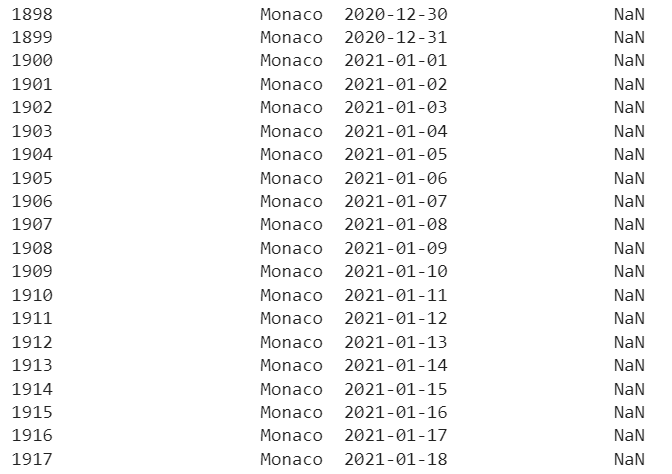

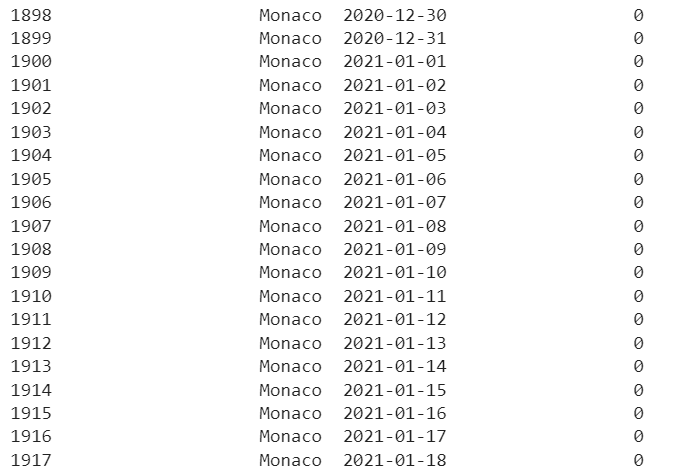

Otros países en los que pasa esto mismo son Bolivia, China, Egipto, Guernsey, India, Kuwait, Liechtenstein, Maldivas, Marruecos, Myanmar, Nepal, Paises Bajos, Norte de Chipre, Panama, Qatar, Isla Santa Elena, Arabia Saudita, Sri Lanka, Suiza y los Emiratos Árabes Unidos.

Vamos a ver cuantos países hay en total en la base de datos para ver si el grupo anterior supone una presencia significativa en el total del conjunto.

In [ ]:
df.country.unique()

array(['Albania', 'Algeria', 'Andorra', 'Anguilla', 'Argentina',
       'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Belgium',
       'Bermuda', 'Bolivia', 'Brazil', 'Bulgaria', 'Cambodia', 'Canada',
       'Cayman Islands', 'Chile', 'China', 'Costa Rica', 'Croatia',
       'Cyprus', 'Czechia', 'Denmark', 'Ecuador', 'Egypt', 'England',
       'Estonia', 'Faeroe Islands', 'Finland', 'France', 'Germany',
       'Gibraltar', 'Greece', 'Greenland', 'Guernsey', 'Hungary',
       'Iceland', 'India', 'Indonesia', 'Iran', 'Ireland', 'Isle of Man',
       'Israel', 'Italy', 'Jersey', 'Kuwait', 'Latvia', 'Liechtenstein',
       'Lithuania', 'Luxembourg', 'Maldives', 'Malta', 'Mauritius',
       'Mexico', 'Monaco', 'Morocco', 'Myanmar', 'Nepal', 'Netherlands',
       'Northern Cyprus', 'Northern Ireland', 'Norway', 'Oman',
       'Pakistan', 'Panama', 'Peru', 'Poland', 'Portugal', 'Qatar',
       'Romania', 'Russia', 'Saint Helena', 'Saudi Arabia', 'Scotland',
       'Serbia', 'Seychelles',

In [ ]:
num_paises = df['country'].nunique()
print("Número total de países en la base de datos:", num_paises)

Número total de países en la base de datos: 90


Antes ya se ha identificado un grupo de países que tienen una característica común: todos sus registros de `people_vaccinated` son NaN.
Vamos a ver si podemos clasificar los países en grupos según la cantidad de missing values que tengan en sus registros.

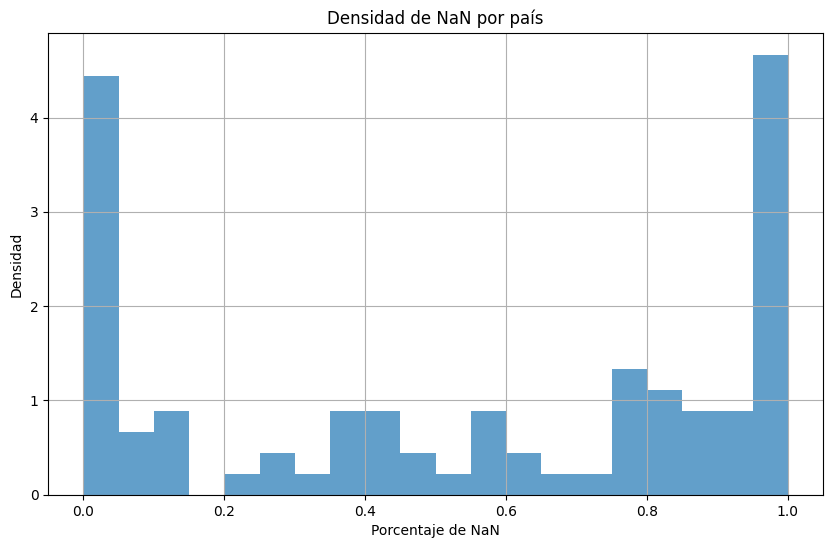

In [ ]:
porcentaje_nan_por_pais = []
# Iterar sobre cada país
for pais in df['country'].unique():
    # Filtrar el DataFrame por país
    df_pais = df[df['country'] == pais]

    # Calcular el porcentaje de NaN
    porcentaje_nan = df_pais['people_vaccinated'].isna().sum() / len(df_pais)
    porcentaje_nan_por_pais.append(porcentaje_nan)

# Crear el gráfico de densidad
plt.figure(figsize=(10, 6))
plt.hist(porcentaje_nan_por_pais, bins=20, density=True, alpha=0.7)

# Añadir etiquetas y título
plt.xlabel('Porcentaje de NaN')
plt.ylabel('Densidad')
plt.title('Densidad de NaN por país')

# Mostrar el gráfico
plt.grid(True)

Se puede observar que la mayor concentración de países se distribuye hacia los extremos de la gráfica.
De acuerdo con la representación visual, vamos a crear 3 categorías en los que clasificar los países:
- Países con menos del 15 % de NaN.
- Países con entre un 15 y un 95% de NaN.
- Países con más de un 95% de Nan.

En cada categoría vamos a seguir un criterio con el que sustituir los NaN y se justificará por qué en cada caso.

Hay algunos países que tienen todos o casi todos los registros de la columna `people_vaccinated` completos. Según el crtierio previamente establecido, aquellos países que tengan menos de un 15% de missing values pertenecen a este grupo.

In [ ]:
# Definir umbral para el porcentaje de NaN
umbral = 0.15

# Crear un DataFrame para almacenar los países que cumplen el criterio
paises_con_menos_nan = []
porcentaje_nan_por_pais = []

# Iterar sobre cada país
for pais in df['country'].unique():
    # Filtrar el DataFrame por país
    df_pais = df[df['country'] == pais]

    # Calcular el porcentaje de NaN
    porcentaje_nan = df_pais['people_vaccinated'].isna().sum() / len(df_pais)
    porcentaje_nan_por_pais.append(porcentaje_nan)

    # Si el porcentaje de NaN es menor al umbral, agregar el país a la lista
    if porcentaje_nan < umbral:
        paises_con_menos_nan.append(pais)

# Imprimir la lista de países que cumplen el criterio
print("Países con menos del 15% de valores faltantes en people_vaccinated:")
print(paises_con_menos_nan)


Países con menos del 15% de valores faltantes en people_vaccinated:
['Austria', 'Bahrain', 'Belgium', 'Brazil', 'Bulgaria', 'Cambodia', 'Chile', 'Czechia', 'Denmark', 'France', 'Germany', 'Gibraltar', 'Greece', 'Greenland', 'Iran', 'Israel', 'Italy', 'Latvia', 'Lithuania', 'Malta', 'Mexico', 'Norway', 'Peru', 'Poland', 'Romania', 'Slovakia', 'Slovenia']


En los países que estamos analizando, la mayoría de los registros contienen información válida y precisa, lo que sugiere que la estrategia de sustituir los valores ausentes (NaNs) con la media de los datos de los días anteriores es una solución adecuada.

Sin embargo, hemos optado por una variación de este enfoque. En lugar de calcular simplemente la media de los tres valores anteriores de "people_vaccinated", nos enfocamos en calcular el incremento de esta variable durante los últimos tres días. Para lograrlo, calculamos la diferencia entre el valor del día anterior y el valor correspondiente al día anterior a ese. Luego, obtenemos la media de estos incrementos y los sumamos al valor inmediatamente anterior al valor ausente que queremos sustituir. Esta adaptación tiene como objetivo preservar la naturaleza acumulativa de la variable y garantizar una aproximación más precisa de la evolución de la vacunación en el tiempo.

In [ ]:
# Iterar sobre cada país
for pais in paises_con_menos_nan:
    # Filtrar el DataFrame por país
    df_pais = df[df['country'] == pais]

    # Obtener los índices de los registros con NaN en people_vaccinated
    indices_nan = df_pais[df_pais['people_vaccinated'].isna()].index

    # Iterar sobre los índices de los registros con NaN
    for idx in indices_nan:
        # Calcular la diferencia entre los valores de los cuatro días anteriores
        diff_values = df_pais.loc[idx-4:idx-1, 'people_vaccinated'].diff().dropna()

        # Verificar si hay suficientes valores para calcular la diferencia
        if len(diff_values) > 0:
            # Calcular la media de las diferencias solo con valores no NaN
            media_diff = round(diff_values[~np.isnan(diff_values)].mean())

            # Sustituir el NaN por el valor calculado
            df_pais.loc[idx, 'people_vaccinated'] = df_pais.loc[idx-1, 'people_vaccinated'] + media_diff
            df.loc[idx, 'people_vaccinated'] = df_pais.loc[idx-1, 'people_vaccinated'] + media_diff
        else:
            # Si no hay suficientes valores para calcular la diferencia, usar el valor del día anterior
            df_pais.loc[idx, 'people_vaccinated'] = df_pais.loc[idx-1, 'people_vaccinated']
            df.loc[idx, 'people_vaccinated'] = df_pais.loc[idx-1, 'people_vaccinated']


Comprobamos con el caso del país Bahrain por ejemplo

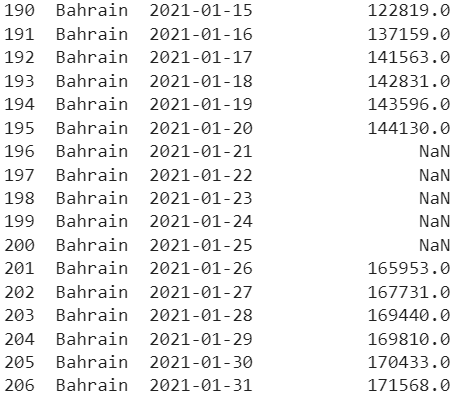

A continuación vemos cómo se sustituyen los NaN de los registros del 196 al 200

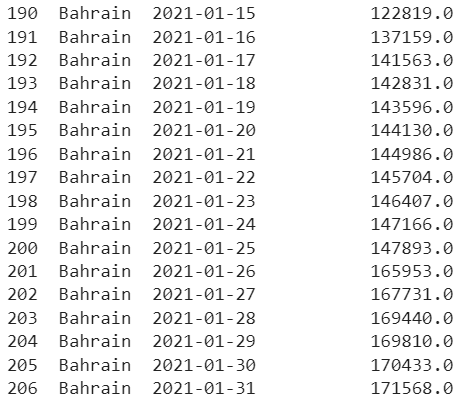

Vamos a ver cuántos missing values quedan por eliminar de la columna people_vaccinated.

In [ ]:
# Contar los valores faltantes en la columna 'People_Vaccinated'
missing_values_people_vaccinated = df['people_vaccinated'].isnull().sum()

# Imprimir el número de valores faltantes en la columna 'People_Vaccinated'
print(f'Valores faltantes en "People_Vaccinated": {missing_values_people_vaccinated}')

Valores faltantes en "People_Vaccinated": 1445


Vemos que con esta estrategia se han eliminado los 36 NaN que había dentro del grupo de países que hemos llamado `paises_con_menos_nan`

In [ ]:
# Filtrar el DataFrame original para incluir solo los países en paises_con_menos_nan:
df_paises_con_menos_nan = df[df['country'].isin(paises_con_menos_nan)]

# Contar los valores faltantes en la columna 'people_vaccinated' de este DataFrame filtrado
missing_values_count = df_paises_con_menos_nan['people_vaccinated'].isnull().sum()

print("Cantidad de missing values en paises_con_menos_nan:", missing_values_count)


Cantidad de missing values en paises_con_menos_nan: 0


El siguiente paso es identificar los países que tengan más de un 95% de missing values en sus registros.

In [ ]:
# Crear una lista para almacenar los países con más del 95% de NaN
paises_mas_del_95_nan = []

# Iterar sobre cada país
for pais in df['country'].unique():
    # Filtrar el DataFrame por país
    df_pais = df[df['country'] == pais]

    # Calcular el porcentaje de NaN
    porcentaje_nan = df_pais['people_vaccinated'].isna().sum() / len(df_pais)
    porcentaje_nan_por_pais.append(porcentaje_nan)

    # Si el porcentaje de NaN es mayor al umbral, agregar el país a la lista
    if porcentaje_nan > 0.95:
        paises_mas_del_95_nan.append(pais)

print("\nPaíses con más del 95% de valores faltantes en people_vaccinated:")
print(paises_mas_del_95_nan)


Países con más del 95% de valores faltantes en people_vaccinated:
['Algeria', 'Bolivia', 'China', 'Egypt', 'India', 'Kuwait', 'Liechtenstein', 'Maldives', 'Monaco', 'Morocco', 'Myanmar', 'Nepal', 'Netherlands', 'Northern Cyprus', 'Panama', 'Qatar', 'Saint Helena', 'Saudi Arabia', 'Sri Lanka', 'Switzerland', 'United Arab Emirates']


Primero vamos a ver cuantos valores faltantes hay en total en el conjunto de estos países.

In [ ]:
df_paises_mas_del_95_nan = df[df['country'].isin(paises_mas_del_95_nan)]

# Contar los valores faltantes en la columna 'people_vaccinated' de este DataFrame filtrado
missing_values_count = df_paises_mas_del_95_nan['people_vaccinated'].isnull().sum()

print("Cantidad de missing values en paises_mas_del_95_nan:", missing_values_count)

Cantidad de missing values en paises_mas_del_95_nan: 487


Volvamos a imprimir el ejemplo de Monaco que comentamos antes

In [ ]:
print(df[['country', 'date', 'people_vaccinated']].iloc[1900:1918])

     country        date  people_vaccinated
1900  Monaco  2021-01-01                NaN
1901  Monaco  2021-01-02                NaN
1902  Monaco  2021-01-03                NaN
1903  Monaco  2021-01-04                NaN
1904  Monaco  2021-01-05                NaN
1905  Monaco  2021-01-06                NaN
1906  Monaco  2021-01-07                NaN
1907  Monaco  2021-01-08                NaN
1908  Monaco  2021-01-09                NaN
1909  Monaco  2021-01-10                NaN
1910  Monaco  2021-01-11                NaN
1911  Monaco  2021-01-12                NaN
1912  Monaco  2021-01-13                NaN
1913  Monaco  2021-01-14                NaN
1914  Monaco  2021-01-15                NaN
1915  Monaco  2021-01-16                NaN
1916  Monaco  2021-01-17                NaN
1917  Monaco  2021-01-18                NaN


En estos países, nos enfrentamos a la falta de información suficiente para completar los valores faltantes, siendo que en muchos de ellos todos los registros son NaN.

Dado que la columna `people_vaccinated` carece de datos útiles (ya que está mayormente o completamente vacía), hemos recurrido a utilizar la información recolectada en la variable `daily_vaccinations`, ya que esta está relacionada con los datos de `people_vaccinated`.

Como se mencionaba al inicio del documento, la variable `people_vaccinated` contiene los datos sobre la cantidad de personas vacunadas hasta la fecha, mientras que `daily_vaccinations` proporciona información sobre la cantidad de vacunas administradas diariamente.

Para sustituir el valor faltante, podemos sumar el número de vacunas administradas cada día hasta la fecha del valor ausente y reemplazarlo con la suma acumulada. Esto permite llenar los vacíos utilizando información relacionada y mantener la coherencia en el conjunto de datos.

In [ ]:
# Iterar sobre los países con más del 95% de NaN
for pais in paises_mas_del_95_nan:
    # Filtrar el DataFrame para el país actual
    df_pais = df[df['country'] == pais]

    # Encontrar los índices de los registros donde 'people_vaccinated' es NaN
    nan_indices = df_pais[df_pais['people_vaccinated'].isnull()].index

    # Iterar sobre los índices de NaN y hacer la suma acumulada hasta cada uno
    for nan_index in nan_indices:
        df.loc[(df['country'] == pais) & (df.index <= nan_index), 'people_vaccinated'] = df_pais['daily_vaccinations'].fillna(0).cumsum()

Vamos a ver cómo se han rellenado los missing values de Monaco

In [ ]:
print(df[['country', 'date', 'people_vaccinated']].iloc[1900:1918])

     country        date  people_vaccinated
1900  Monaco  2021-01-01              252.0
1901  Monaco  2021-01-02              378.0
1902  Monaco  2021-01-03              504.0
1903  Monaco  2021-01-04              630.0
1904  Monaco  2021-01-05              756.0
1905  Monaco  2021-01-06              882.0
1906  Monaco  2021-01-07             1008.0
1907  Monaco  2021-01-08             1134.0
1908  Monaco  2021-01-09             1260.0
1909  Monaco  2021-01-10             1386.0
1910  Monaco  2021-01-11             1512.0
1911  Monaco  2021-01-12             1638.0
1912  Monaco  2021-01-13             1764.0
1913  Monaco  2021-01-14             1890.0
1914  Monaco  2021-01-15             2016.0
1915  Monaco  2021-01-16             2142.0
1916  Monaco  2021-01-17             2268.0
1917  Monaco  2021-01-18             2394.0


Comprobamos que se han eliminado todos los NaN de los países pertenecientes a esta categoría

In [ ]:
df_paises_mas_del_95_nan = df[df['country'].isin(paises_mas_del_95_nan)]

# Contar los valores faltantes en la columna 'people_vaccinated' de este DataFrame filtrado
missing_values_count = df_paises_mas_del_95_nan['people_vaccinated'].isnull().sum()

print("Cantidad de missing values en paises_mas_del_95_nan:", missing_values_count)

Cantidad de missing values en paises_mas_del_95_nan: 0


Por último, queda sustituir los missing values de los países que tienen entre un 15 y un 95% de NaNs.

Para estos casos se ha decidido emplear la regresión lineal para realizar interpolación y reemplazar los valores NaN en los conjuntos de datos carentes de información.

Esta decisión se fundamenta en razones sólidas y bien definidas. En primer lugar, la presencia significativa de NaNs, representando entre el 15% y el 95% del total de los datos, implica la necesidad de abordar esta compleja situación con una estrategia que sea lo suficientemente robusta para manejar una cantidad considerable de datos faltantes.

La regresión lineal emerge como una herramienta apropiada para enfrentar este desafío, ya que permite modelar la relación lineal entre las variables conocidas y, por lo tanto, estimar de manera coherente los valores desconocidos. Dado que más del 15% de los datos se encuentran ausentes, existe una base estadística adecuada derivada de los datos disponibles, lo que justifica la aplicación de técnicas más sofisticadas como la regresión lineal.

Además, la regresión lineal aprovecha la relación temporal entre las variables, aspecto particularmente relevante en el contexto de datos relacionados con la vacunación, donde la progresión a lo largo del tiempo desempeña un papel fundamental.

Por consiguiente, la selección de la regresión lineal como método de interpolación se sustenta tanto en la complejidad inherente de la situación, dada la notable cantidad de datos faltantes, como en la existencia de una base estadística suficiente derivada de los datos conocidos. Esta elección respalda la implementación de un enfoque más refinado para abordar la tarea de reemplazar los valores ausentes de manera precisa y coherente en los conjuntos de datos.

Mostraremos como ejemplo el caso de Andorra.

In [ ]:
andorra_data_old = df[df['country'] == 'Andorra']

 Inicialmente, se convierte la columna de fechas al formato adecuado y luego la transforma en números ordinales para utilizarla como una variable independiente en el proceso de interpolación.

A continuación, se seleccionan los países para los cuales se realizará la interpolación. Como ya hemos dicho antes, estos países son aquellos que no tienen un porcentaje extremadamente alto o bajo de valores faltantes en 'people_vaccinated'.

Luego, se itera sobre cada uno de los países seleccionados. Se verifica si existen valores faltantes (NaN) en la columna 'people_vaccinated'. Si se encuentran valores NaN, se procede con la interpolación utilizando un modelo de regresión lineal.

Se entrena un modelo de regresión lineal utilizando los números ordinales de las fechas como variables independientes y los valores conocidos de 'people_vaccinated' como variable dependiente. Después de entrenar el modelo, se utilizan las fechas correspondientes a los valores NaN para predecir los valores faltantes de 'people_vaccinated'.

Finalmente, los valores predichos se redondean a enteros y se utilizan para reemplazar los valores faltantes en 'people_vaccinated' para el país en cuestión. Este proceso se repite para cada país seleccionado, lo que permite completar y actualizar los datos de vacunación en el DataFrame.

In [ ]:
# Convertir la columna 'date' en formato de fecha
df['date'] = pd.to_datetime(df['date'])

# Convertir las fechas a números ordinales
df['ordinal_date'] = df['date'].apply(lambda x: x.toordinal())

# Lista de países que no pertenecen a las dos categorías anteriores
paises_interpolacion = df['country'][~df['country'].isin(paises_mas_del_95_nan + paises_con_menos_nan)]

# Realizar la interpolación para los países seleccionados
for pais in paises_interpolacion:
    # Seleccionar los datos del país actual
    data_pais = df[df['country'] == pais]

    # Aplicar interpolación lineal solo si hay NaN presentes
    if data_pais['people_vaccinated'].isnull().sum() > 0:
        # Crear un modelo de regresión lineal
        model = LinearRegression()

        # Eliminar las filas con valores NaN para poder entrenar el modelo
        data_pais_clean = data_pais.dropna(subset=['people_vaccinated', 'ordinal_date'])

        # Entrenar el modelo de regresión lineal utilizando los números ordinales de las fechas como variable independiente
        X_train = data_pais_clean['ordinal_date'].values.reshape(-1, 1)
        y_train = data_pais_clean['people_vaccinated'].values.reshape(-1, 1)
        model.fit(X_train, y_train)

        # Predecir los valores NaN utilizando el modelo entrenado
        X_pred = data_pais[data_pais['people_vaccinated'].isnull()]['ordinal_date'].values.reshape(-1, 1)
        y_pred = model.predict(X_pred)

        # Rellenar los valores NaN con los valores predichos
        df.loc[(df['country'] == pais) & (df['people_vaccinated'].isnull()), 'people_vaccinated'] = np.round(y_pred).flatten().astype(int)


Vamos a seleccionar los datos correspondientes al país de Andorra del DataFrame principal y crea una copia de estos datos para trabajar con ellos. Vamos a hacer un análisis de regresión lineal sobre los datos de vacunación de Andorra para modelar la evolución de 'people_vaccinated' a lo largo del tiempo y visualiza tanto los datos originales como la recta de regresión obtenida.






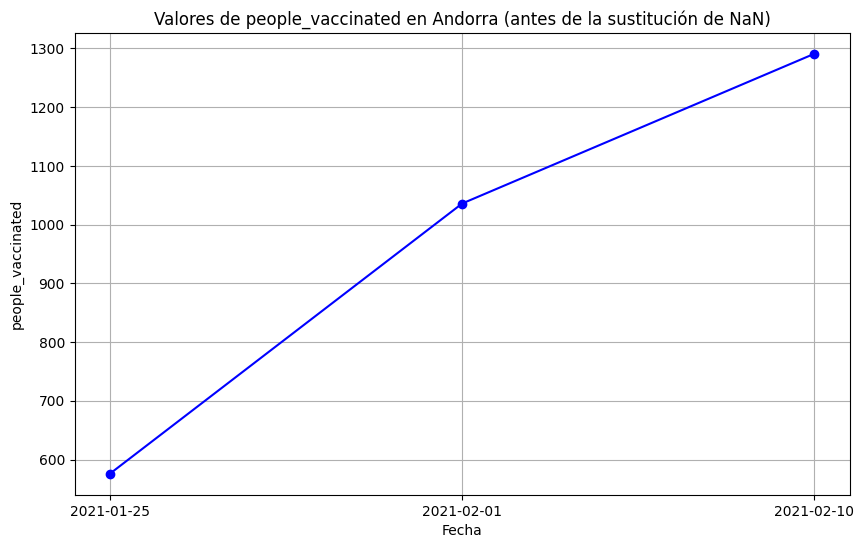

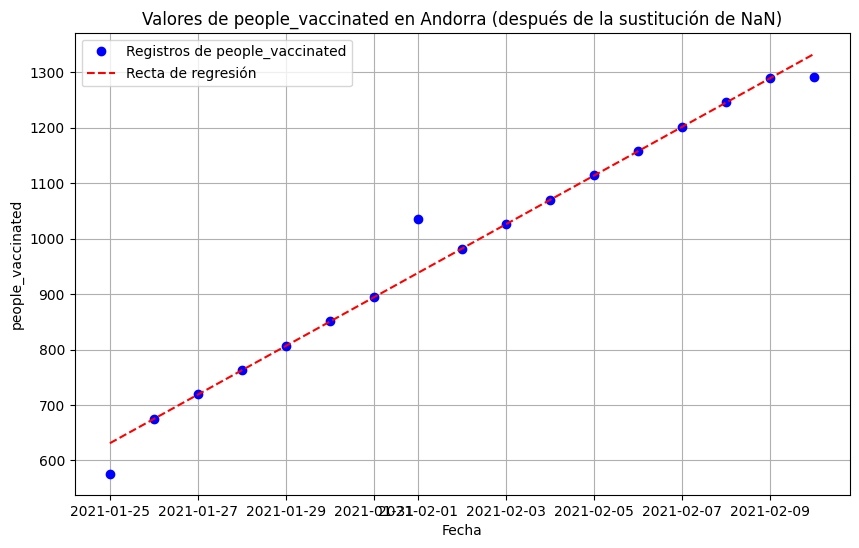

In [ ]:
# Seleccionar los datos para el país de Andorra
andorra_data = df[df['country'] == 'Andorra'].copy()

# Convertir la columna 'date' en formato de fecha
andorra_data['date'] = pd.to_datetime(andorra_data['date'])

# Convertir las fechas a números ordinales
andorra_data['ordinal_date'] = andorra_data['date'].apply(lambda x: x.toordinal())

# Eliminar las filas con valores NaN para poder entrenar el modelo
andorra_data_clean = andorra_data.dropna(subset=['people_vaccinated', 'ordinal_date'])

# Crear un modelo de regresión lineal
model = LinearRegression()

# Entrenar el modelo de regresión lineal utilizando los números ordinales de las fechas como variable independiente
X_train = andorra_data_clean['ordinal_date'].values.reshape(-1, 1)
y_train = andorra_data_clean['people_vaccinated'].values.reshape(-1, 1)
model.fit(X_train, y_train)

# Calcular la recta de regresión
reg_line_x = np.array([andorra_data['ordinal_date'].min(), andorra_data['ordinal_date'].max()]).reshape(-1, 1)
reg_line_y = model.predict(reg_line_x)

# Gráfica antes de la sustitución de NaN
plt.figure(figsize=(10, 6))
plt.plot(andorra_data_old['date'][~andorra_data_old['people_vaccinated'].isnull()], andorra_data_old['people_vaccinated'][~andorra_data_old['people_vaccinated'].isnull()], marker='o', linestyle='-', color='b')
plt.title('Valores de people_vaccinated en Andorra (antes de la sustitución de NaN)')
plt.xlabel('Fecha')
plt.ylabel('people_vaccinated')
plt.grid(True)
plt.show()


# Gráfica después de la sustitución de NaN
plt.figure(figsize=(10, 6))
plt.plot(andorra_data['date'], andorra_data['people_vaccinated'], marker='o', linestyle='', color='b', label='Registros de people_vaccinated')
plt.plot(andorra_data['date'], model.predict(andorra_data['ordinal_date'].values.reshape(-1, 1)), color='r', linestyle='--', label='Recta de regresión')
plt.xlabel('Fecha')
plt.ylabel('people_vaccinated')
plt.title('Valores de people_vaccinated en Andorra (después de la sustitución de NaN)')
plt.legend()
plt.grid(True)
plt.show()

Después de observar las gráficas de los valores de `people_vaccinated` antes y después de la sustitución de NaNs, se pueden sacar varias conclusiones:

1. **Completitud de los datos:** La sustitución de NaNs ha permitido llenar los vacíos en los datos de vacunación de Andorra, lo que resulta en una serie temporal más completa y continua.

2. **Tendencia general:** Ambas gráficas muestran una tendencia general similar en el aumento de los valores de 'people_vaccinated' con el tiempo. Esto sugiere que la interpolación realizada mediante regresión lineal ha sido efectiva para capturar la tendencia subyacente de la variable.

3. **Justificación de la regresión lineal:** La regresión lineal parece ser una buena opción para la interpolación en este caso por varias razones. Primero, los datos de vacunación tienden a mostrar una tendencia lineal de crecimiento con el tiempo, lo que hace que la regresión lineal sea adecuada para capturar esta relación. Además, la regresión lineal es un método simple y fácil de interpretar, lo que facilita su aplicación en situaciones donde se requiere una interpolación precisa de los datos faltantes.


Vamos a ver también cómo se dan valores a los NaNs en el DataFrame

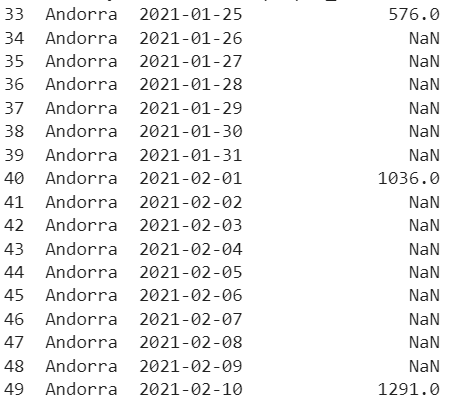

Debajo se muestra el resultado de la sustitución de los missing values.

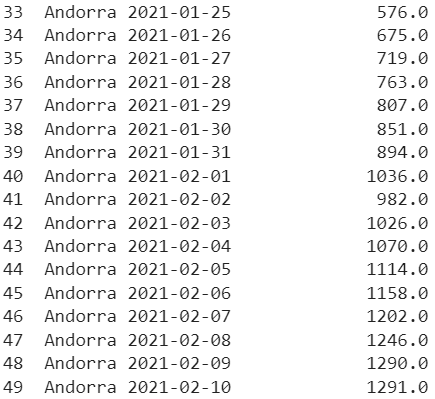

Vamos a comprobar que se han sustituido todos los NaN de la columna de gente vacunada.

In [ ]:
# Contar los valores faltantes en la columna 'People_Vaccinated'
missing_values_people_vaccinated = df['people_vaccinated'].isnull().sum()

# Imprimir el número de valores faltantes en la columna 'People_Vaccinated'
print(f'Valores faltantes en "People_Vaccinated": {missing_values_people_vaccinated}')

Valores faltantes en "People_Vaccinated": 0


**2. - De aquellos 5 países que han vacunado más días en total compara su evolución en el tiempo
(no importa que en algunas fechas no coincidan). ¿Qué diagrama has usado? ¿Porqué? Teniendo en
cuenta que el mejor plan de vacunación es el que se mantiene más constante ¿Cuál es el país que mejor
está llevando a cabo la vacunación? Haz una interpretación de dicho plan de vacunación.**

In [ ]:
# Convertir la columna 'date' a tipo datetime
df['date'] = pd.to_datetime(df['date'])

# Calcular el total de días de vacunación por país
total_vaccination_days = df.groupby('country')['date'].nunique().sort_values(ascending=False)

# Seleccionar los 5 países con más días de vacunación en total
top_5_countries = total_vaccination_days.head(5)

print("Los 5 países que han vacunado más días en total son:")
# Crear un nuevo DataFrame con los datos de top_5_countries
top_5_countries_df = top_5_countries.reset_index()

# Renombrar las columnas del nuevo DataFrame
top_5_countries_df.columns = ['País', 'Total de días de vacunación']

# Imprimir los datos en forma de tabla
print(top_5_countries_df.to_string(index=False))


Los 5 países que han vacunado más días en total son:
            País  Total de días de vacunación
           Wales                           64
         England                           64
        Scotland                           64
Northern Ireland                           64
  United Kingdom                           64


Para comparar la evolución en el tiempo de los 5 países que han vacunado más días en total, se podría utilizar un diagrama de líneas. Este tipo de diagrama es útil cuando se quiere visualizar cómo cambian las variables a lo largo del tiempo.

El mejor plan de vacunación sería aquel que mantiene una tendencia constante en el número de días de vacunación, lo que indicaría una distribución uniforme y eficiente de las vacunas a lo largo del tiempo.

Para determinar qué país está llevando a cabo la vacunación de manera más efectiva, se podría analizar la estabilidad de la línea en el diagrama de líneas. Si un país tiene una línea más constante y menos fluctuante a lo largo del tiempo, podría interpretarse como un indicador de un plan de vacunación más sólido y eficiente.



Dado que queremos identificar el país que está llevando a cabo la vacunación de manera más efectiva, es importante considerar la variable que refleje la cantidad de vacunaciones realizadas en relación con la población total del país. Por lo tanto, la variable más adecuada sería "Daily vaccinations per million", ya que nos proporcionaría una medida estandarizada que nos permitiría comparar la eficiencia de la vacunación entre países con poblaciones diferentes.

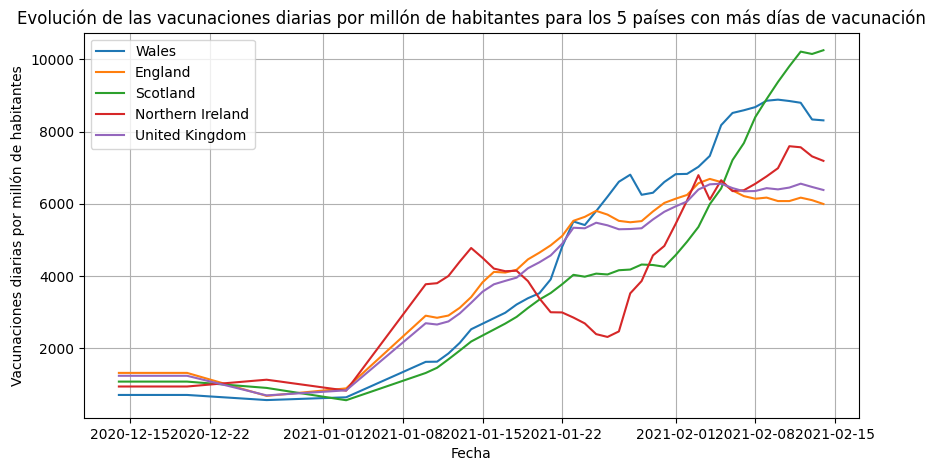

In [ ]:
# Seleccionar los datos de los 5 países
top_5_data = df[df['country'].isin(top_5_countries.index)]

# Graficar la evolución de las vacunaciones diarias por millón de habitantes para los 5 países
plt.figure(figsize=(10, 5))
for country in top_5_countries.index:
    country_data = top_5_data[top_5_data['country'] == country]
    plt.plot(country_data['date'], country_data['daily_vaccinations_per_million'], label=country)

plt.xlabel('Fecha')
plt.ylabel('Vacunaciones diarias por millón de habitantes')
plt.title('Evolución de las vacunaciones diarias por millón de habitantes para los 5 países con más días de vacunación')
plt.legend()
plt.grid(True)
plt.show()

Basándonos en el comportamiento de las vacunaciones diarias por millón de habitantes para los cinco países con más días de vacunación, Escocia emerge como el país con la estrategia de vacunación más consistente y exitosa. Este análisis se sustenta en varias observaciones clave.

Escocia muestra una tendencia relativamente estable en la administración de vacunas a lo largo del tiempo, con cambios mínimos en las vacunaciones diarias por millón de habitantes. Esta estabilidad sugiere una planificación y ejecución efectivas del programa de vacunación, lo que puede reflejar una buena gestión logística y una distribución constante de las vacunas.

A diferencia de otros países como Northern Island, Escocia presenta menos fluctuaciones abruptas en la cantidad de vacunas administradas por día. Esta consistencia indica una implementación coherente de la estrategia de vacunación y una capacidad para mantener un ritmo constante de inoculaciones, lo que es crucial para alcanzar altos niveles de cobertura de vacunación en la población.

Además, al observar el final de la gráfica, Escocia alcanza los valores más altos en el eje y, lo que sugiere que ha logrado mantener una tasa de vacunación por habitante significativamente elevada en comparación con los otros países. Esto puede indicar una alta eficiencia en la distribución de vacunas y una capacidad para adaptarse y mejorar continuamente el proceso de vacunación.

En conclusión, la estabilidad en la tendencia, la menor variabilidad y la capacidad para alcanzar valores más altos al final del período analizado respaldan la idea de que Escocia está implementando una estrategia de vacunación efectiva y bien ejecutada. Esto sugiere que Escocia está siguiendo una estrategia sólida y constante que maximiza el impacto de la vacunación en la población, lo que la convierte en un líder en la gestión de la vacunación contra la COVID-19.

Vamos a dibujar más gráficas para confirmar que Escocia es el país que tiene el mejor plan de vacunación.

La variable `daily_vaccinations` puede ser otra opción para analizar la evolución temporal de la vacunación en un país debido a su capacidad para indicar el ritmo de vacunación diario. Proporciona información sobre cuántas vacunas se administran en un país en un día específico, lo que permite evaluar el ritmo de vacunación y su velocidad relativa en comparación con días anteriores. Además, al observar cómo varían las vacunaciones diarias a lo largo del tiempo, es posible identificar tendencias, como aumentos o disminuciones en la velocidad de vacunación, que pueden estar relacionados con la disponibilidad de vacunas o cambios en la política de vacunación. Esta variable también facilita la comparación entre países, ya que proporciona una medida estándar de la actividad de vacunación en términos absolutos (número de vacunaciones por día), lo que permite evaluar la eficiencia de los programas de vacunación.

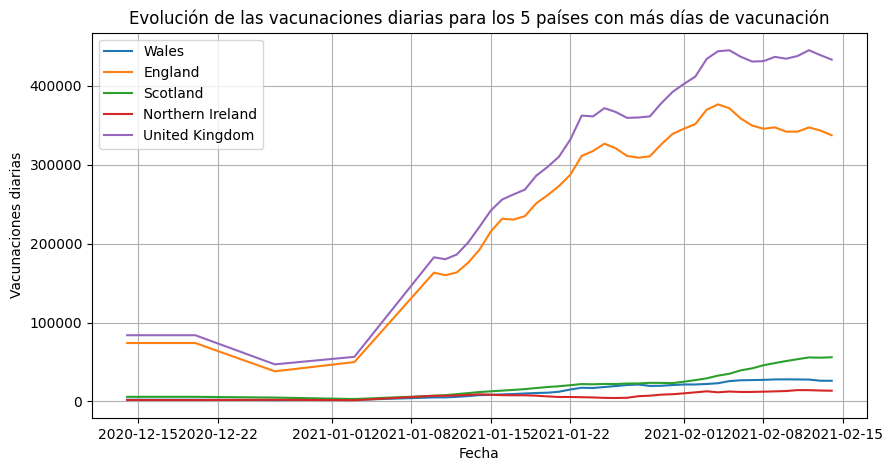

In [ ]:
# Graficar la evolución de las vacunaciones diarias para los 5 países
plt.figure(figsize=(10, 5))
for country in top_5_countries.index:
    country_data = top_5_data[top_5_data['country'] == country]
    plt.plot(country_data['date'], country_data['daily_vaccinations'], label=country)

plt.xlabel('Fecha')
plt.ylabel('Vacunaciones diarias')
plt.title('Evolución de las vacunaciones diarias para los 5 países con más días de vacunación')
plt.legend()
plt.grid(True)
plt.show()

Basándonos en la nueva gráfica que muestra los datos de daily_vaccinations para los cinco países, podemos corroborar y fortalecer aún más la conclusión de que Escocia sigue el mejor plan de vacunación. Esta afirmación se sustenta en varios puntos adicionales.

Aunque England y United Kingdom registran cifras notoriamente más altas en términos absolutos de vacunaciones diarias, estas dos naciones también muestran grandes fluctuaciones en la cantidad de vacunas administradas a lo largo del tiempo. Esta variabilidad puede indicar desafíos en la distribución de vacunas, interrupciones en el suministro o cambios en las políticas de vacunación que afectan la consistencia del programa.

Por otro lado, los otros tres países, incluyendo a Escocia, muestran curvas más suaves y constantes en la gráfica de vacunaciones diarias. Esta estabilidad sugiere una ejecución más coherente y menos sujeta a cambios bruscos en la estrategia de vacunación. La capacidad de mantener un ritmo constante de vacunación es fundamental para garantizar una cobertura amplia y eficaz en la población.

Además, al analizar las tres curvas más suaves, la de Escocia se destaca al mantenerse por encima de las otras dos. Esto indica que, a pesar de mantener una tendencia estable, Escocia logra administrar un mayor número de vacunas diarias en comparación con los otros países que muestran una consistencia similar. Esta eficiencia en la distribución y aplicación de vacunas refuerza la idea de que Escocia sigue un plan de vacunación efectivo y bien planificado.

## Práctica 2: Sensores atmosféricos


**1.- Llevar a cabo el estudio de los outliers de 3 variables (Wind_speed, Ozone_reading, Visibility) de forma unidimensional. ¿Qué tipo de gráfico es necesario emplear? Interpretar los datos obtenidos en cada caso.**


Primero se van a eliminar las comillas de las variables. Sin este paso no se pueden seleccionar las columnas que queremos analizar. Una vez se consiguen se dibujan para observar sus outliers

Conocimiento del dominio previo:

**Month:** Variable categórica que representa el mes del año (por ejemplo, 1 para enero, 2 para febrero, etc.).

**Day_of_month:** Variable numérica que representa el día del mes en el que se tomó la lectura.

**Day_of_week:** Variable numérica que representa el día de la semana en el que se tomó la lectura (1 para lunes, 2 para martes, etc.).

**ozone_reading:** Concentración de ozono medida en partes por millón (ppm) o microgramos por metro cúbico (µg/m³).

**pressure_height:** Altitud a la que se midió la presión.

**Wind_speed:** Velocidad del viento medida según la escala de Beaufort.

**Humidity:** Humedad relativa medida en porcentaje (%).

**Temperature_Sandburg:** Temperatura medida en Fahrenheit (°F) en la ubicación Sandburg.

**Temperature_ElMonte:** Temperatura medida en Fahrenheit (°F) en la ubicación El Monte.

**Inversion_base_height:** Altura a la que comienza una inversión térmica en la atmósfera. Una inversión térmica es un fenómeno meteorológico en el que la temperatura aumenta con la altura en lugar de disminuir, como es típico en la atmósfera.

**Pressure_gradient:** Gradiente de presión medido en hectopascales por kilómetro (hPa/km) o libras por pulgada cuadrada por milla (psi/mi).

**Inversion_temperature:** Temperatura medida en grados Fahrenheit (°F) en la inversión.

**Visibility:** Visibilidad medida en kilómetros (km), metros (m), millas (mi), o alguna otra unidad de distancia.

In [ ]:
# Leer el archivo CSV y dividir los nombres de las columnas
with open("ozone.csv") as f:
    columns = f.readline().strip().split(',')

# Eliminar las comillas y espacios adicionales de cada nombre de columna
columns = [name.strip('"') for name in columns]

# Cargar los datos en un DataFrame y asignar los nombres de columna
data = pd.read_csv("ozone.csv", skiprows=1, names=columns)

# Variables a analizar
variables = ["Wind_speed", "ozone_reading", "Visibility"]

# Seleccionar las variables de interés
data_subset = data[variables]

print(data)

     Month  Day_of_month  Day_of_week  ozone_reading  pressure_height  \
0        1             5            1           5.34             5760   
1        1             6            2           5.77             5720   
2        1             7            3           3.69             5790   
3        1             8            4           3.89             5790   
4        1             9            5           5.76             5700   
..     ...           ...          ...            ...              ...   
198     12            23            4           3.21             5680   
199     12            27            1           1.74             5730   
200     12            28            2           2.69             5690   
201     12            29            3           5.05             5650   
202     12            30            4           0.72             5550   

     Wind_speed  Humidity  Temperature_Sandburg  Temperature_ElMonte  \
0             3        51                    54    

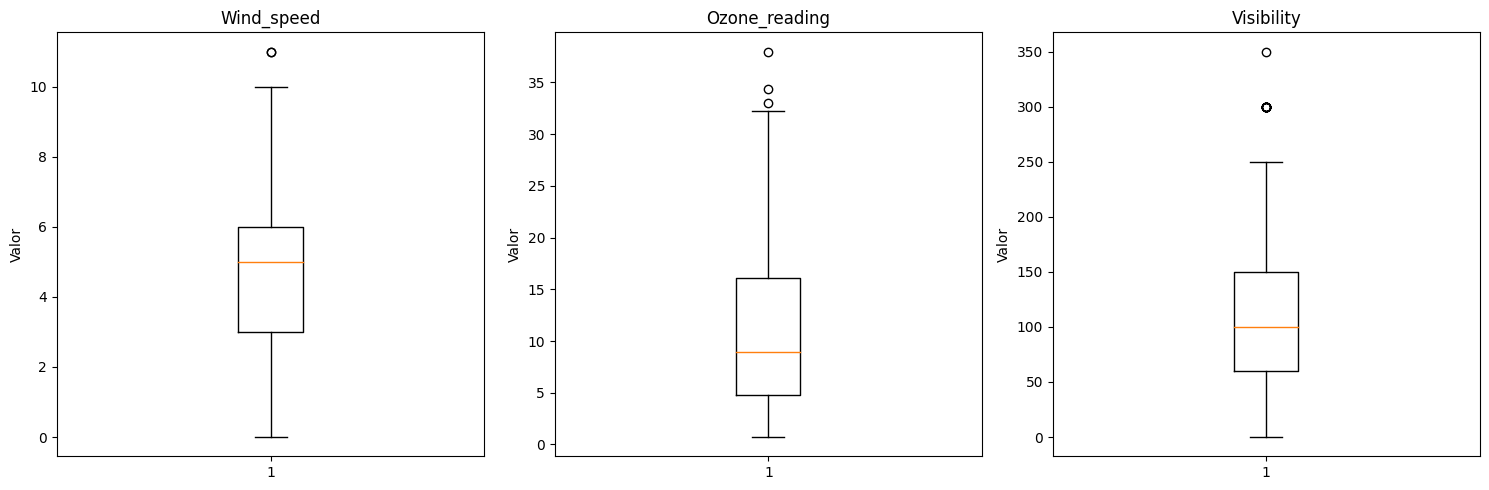

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Boxplot para Wind_speed
axs[0].boxplot(data_subset['Wind_speed'])
axs[0].set_title('Wind_speed')
axs[0].set_ylabel('Valor')

# Boxplot para Ozone_reading
axs[1].boxplot(data_subset['ozone_reading'])
axs[1].set_title('Ozone_reading')
axs[1].set_ylabel('Valor')


# Boxplot para Visibility
axs[2].boxplot(data_subset['Visibility'])
axs[2].set_title('Visibility')
axs[2].set_ylabel('Valor')

plt.tight_layout()
plt.show()

Se van a estudiar los outliers mediante la fórmula de los cuartiles. Primero, se ordenarán los datos de la distribución de menor a mayor, luego se calcularán Q1 y Q3. Estos son la media de los valores que están en la frontera del 25% y del 75% de los datos. Para encontrar los valores atípicos usaremos: valores <Q1 -1,5*IQR o valores > Q3 +1,5*IQR teniendo en cuenta que IQR=Q3 - Q1.

In [ ]:
# Función para calcular Q1
def calcular_Q1(columna):
    q1_index = int(len(columna) / 4)
    return (columna.sort_values().iloc[q1_index] + columna.sort_values().iloc[q1_index + 1]) / 2

# Función para calcular Q3
def calcular_Q3(columna):
    q3_index = int(3 * len(columna) / 4)
    return (columna.sort_values().iloc[q3_index] + columna.sort_values().iloc[q3_index + 1]) / 2

# Calcula Q1 y Q3 para cada columna
Q1_values = data_subset.apply(calcular_Q1)
Q3_values = data_subset.apply(calcular_Q3)

# Muestra los resultados
print("Q1:", Q1_values)
print("Q3:", Q3_values)

Q1: Wind_speed        3.00
ozone_reading     4.77
Visibility       60.00
dtype: float64
Q3: Wind_speed         6.000
ozone_reading     16.415
Visibility       150.000
dtype: float64


In [ ]:
# Calcula IQR para cada columna
IQR_values = Q3_values - Q1_values

# Calcula los límites para valores atípicos
lim_inferior = Q1_values - 1.5 * IQR_values
lim_superior = Q3_values + 1.5 * IQR_values

# Encuentra los valores atípicos para cada columna
valores_atipicos = (data_subset < lim_inferior) | (data_subset > lim_superior)

# Muestra los resultados
print("\nIQR:")
print(IQR_values)
print("\nLímites inferiores para valores atípicos:")
print(lim_inferior)
print("\nLímites superiores para valores atípicos:")
print(lim_superior)
for variable in variables:
    valores_salientes = data_subset.loc[valores_atipicos[variable], variable]
    print(f"Valores atípicos para {variable}:")
    print(valores_salientes)
    print()


IQR:
Wind_speed        3.000
ozone_reading    11.645
Visibility       90.000
dtype: float64

Límites inferiores para valores atípicos:
Wind_speed       -1.5000
ozone_reading   -12.6975
Visibility      -75.0000
dtype: float64

Límites superiores para valores atípicos:
Wind_speed        10.5000
ozone_reading     33.8825
Visibility       285.0000
dtype: float64
Valores atípicos para Wind_speed:
22    11
36    11
Name: Wind_speed, dtype: int64

Valores atípicos para ozone_reading:
103    34.39
129    37.98
Name: ozone_reading, dtype: float64

Valores atípicos para Visibility:
22     350
23     300
24     300
28     300
29     300
30     300
35     300
42     300
54     300
58     300
59     300
64     300
162    300
166    300
185    300
187    300
197    300
Name: Visibility, dtype: int64



Una vez hemos encontrado los límites y los valores atípicos, podemos comprobar que no parecen ser errores de medicion. En el caso de Wind_speed, se está midiendo según la escala de Beaufort, esta va del 0-12 donde 0 es un viento muy calmado y 12 es temporal huracanado. Por lo que, los vientos de 11 son temporales muy duros y los considera outliers, pero no incorrectos. Si hubiera un viento con valor 20, por ejemplo, sería un error de medición, ya que la escala no admite ese valor.

Para la variable ozone_reading, se supera el límite superior dos veces, cuando hablamos de cantidad de ozono quiere decir que el aire comienza a ser contaminante y peligroso. Los valores de esta variable oscilan entre 15 y 21 aproximadamente. Por lo que tener dos días con 34 y 37 son valores peligrosos. Aún así, debemos observar el contexto para saber que otros acontecimientos ocurrieron ese día. Para ello, veremos donde se han dado esos valores y qué coindiciones meteorológicas hubo en esos días, si son similares consideraremos que los datos son correctos.

Por último, la variable 'Visibility' es la que más outliers tiene, ya que su límite superior es 285 y hay muchos valores con 300 o 350. Estos valores pueden darse en condiciones meteorológicas ideales, pero hay muchos para ser outliers, 'poco comunes'.

Ahora vamos a ver el contexto de las variables para evaluar sus outliers

In [ ]:
# Obtener los índices de las filas que contienen valores atípicos
indices_valores_atipicos = data[valores_atipicos.any(axis=1)].index

# Mostrar los índices de las filas que contienen valores atípicos
print("Índices de filas que contienen valores atípicos:")
print(indices_valores_atipicos)

Índices de filas que contienen valores atípicos:
Int64Index([ 22,  23,  24,  28,  29,  30,  35,  36,  42,  54,  58,  59,  64,
            103, 129, 162, 166, 185, 187, 197],
           dtype='int64')


### Contexto outliers Wind_speed

In [ ]:
# Obtener los índices de las filas que contienen valores atípicos de Wind_speed
indices_valores_atipicos_wind_speed = valores_atipicos["Wind_speed"][valores_atipicos["Wind_speed"]].index

# Seleccionar dos índices aleatorios adicionales
np.random.seed(42)
indices_aleatorios = np.random.choice(data.index, 2, replace=False)

# Combinar los índices de los valores atípicos de Wind_speed y los índices aleatorios
indices_para_mostrar = np.concatenate([indices_valores_atipicos_wind_speed, indices_aleatorios])

# Mostrar las filas correspondientes a estos índices
print("Filas con valores atípicos de Wind_speed y dos días adicionales al azar para comparar:")
print(data.loc[indices_para_mostrar])

Filas con valores atípicos de Wind_speed y dos días adicionales al azar para comparar:
    Month  Day_of_month  Day_of_week  ozone_reading  pressure_height  \
22      2             9            1           2.92             5490   
36      3             3            3           2.79             5320   
15      1            29            4           5.68             5810   
9       1            16            5           7.00             5870   

    Wind_speed  Humidity  Temperature_Sandburg  Temperature_ElMonte  \
22          11        72                    37                38.48   
36          11        45                    25                27.68   
15           5        19                    64                56.66   
9            2        19                    61                64.94   

    Inversion_base_height  Pressure_gradient  Inversion_temperature  \
22                   5000                 32                  38.12   
36                   5000                 39          

Los índices con valores atípicos son el 22 y el 36. Podemos observar que estos dos valores se dieron en los dos primeros meses del año con un ozone_reading considerablemente bajo, esto tiene sentido ya que con más viento menos contaminación. Por otro lado, la temperatura en Sandburg(Hamburgo) suele oscilar entre -1 y 4 grados en los primeros meses del año, por lo que los fuertes vientos pueden traer temperaturas muy bajas. En estos dos días de viento extremo se detectan temperaturas de 2.77 y -3.8 grados (Farenheit-> grados TF - 32 * 5/9). La segunda es demasiado baja, coincidiendo a su vez con un pressure_gradient muy alto y una inversion_temperature muy baja. [1][2]

### Contexto ozone_reading


In [ ]:
# Obtener los índices de las filas que contienen valores atípicos de ozone_reading
indices_valores_atipicos_ozone_reading = valores_atipicos["ozone_reading"][valores_atipicos["ozone_reading"]].index

# Seleccionar dos índices aleatorios adicionales
np.random.seed(42)
indices_aleatorios2 = np.random.choice(data.index, 2, replace=False)

# Combinar los índices de los valores atípicos de Wind_speed y los índices aleatorios
indices_para_mostrar2 = np.concatenate([indices_valores_atipicos_ozone_reading, indices_aleatorios2])

# Mostrar las filas correspondientes a estos índices
print("Filas con valores atípicos de ozone_reading y dos días adicionales al azar para comparar:")
print(data.loc[indices_para_mostrar2])

Filas con valores atípicos de ozone_reading y dos días adicionales al azar para comparar:
     Month  Day_of_month  Day_of_week  ozone_reading  pressure_height  \
103      7             6            2          34.39             5900   
129      8            30            1          37.98             5950   
15       1            29            4           5.68             5810   
9        1            16            5           7.00             5870   

     Wind_speed  Humidity  Temperature_Sandburg  Temperature_ElMonte  \
103           6        86                    87                81.68   
129           5        62                    92                82.40   
15            5        19                    64                56.66   
9             2        19                    61                64.94   

     Inversion_base_height  Pressure_gradient  Inversion_temperature  \
103                    990                 22                  85.10   
129                    557             

Los valores atípicos son el 103 y el 129, ambos en meses seguidos. Hay que destacar que hay mucha diferencia en algunas variables entre los outliers y los valores normales. En el caso de la humedad y la temperatura vemos que a mayor ozone_reading hay más humedad y hace más calor. Esto tiene sentido, ya que con calor y humedad la contaminación es más alta. Además, estas temperaturas provocan un aumento de la inversión térmica. En el caso de estos outliers, la temperatura de inversión es muy alta comparada con las demás. Otras consecuencias que se pueden observar son la temperatura de inversión y la visibilidad. Con mucha contaminación se ve muy poco, en comparación con los datos 15 y 9, cuyo valor de ozone_reading es muy bajo, y por ello, su visibilidad muy alta.

### Contexto Visibility

In [ ]:
# Obtener los índices de las filas que contienen valores atípicos de ozone_reading
indices_valores_atipicos_Visibility = valores_atipicos["Visibility"][valores_atipicos["Visibility"]].index

# Seleccionar dos índices aleatorios adicionales
np.random.seed(4)
indices_aleatorios3 = np.random.choice(data.index, 2, replace=False)

# Combinar los índices de los valores atípicos de Wind_speed y los índices aleatorios
indices_para_mostrar3 = np.concatenate([indices_valores_atipicos_Visibility, indices_aleatorios3])

# Mostrar las filas correspondientes a estos índices
print("Filas con valores atípicos de Visibility y dos días adicionales al azar para comparar:")
print(data.loc[indices_para_mostrar3])

Filas con valores atípicos de Visibility y dos días adicionales al azar para comparar:
     Month  Day_of_month  Day_of_week  ozone_reading  pressure_height  \
22       2             9            1           2.92             5490   
23       2            10            2           4.08             5560   
24       2            12            4           8.32             5680   
28       2            20            5           5.73             5690   
29       2            23            1           4.04             5690   
30       2            24            2           6.04             5640   
35       3             2            2           3.22             5470   
42       3            12            5           7.63             5690   
54       3            31            3          12.33             5710   
58       4             6            2           9.32             5590   
59       4             7            3          13.12             5690   
64       4            14            3

Como podemos observar, la cantidad de outliers en visibility es mucho mayor que en las otras variables observadas. En este caso, una alta visibilidad, debe corresponderse con unas condiciones meteorológicas buenas, por lo que hemos observado antes. Comparando con los datos 1 y 24, deben ser unas condiciones mejores en general. Pero, debido a la gran cantidad de datos atípicos, vamos a representar en una gráfica la tendencia de estos:

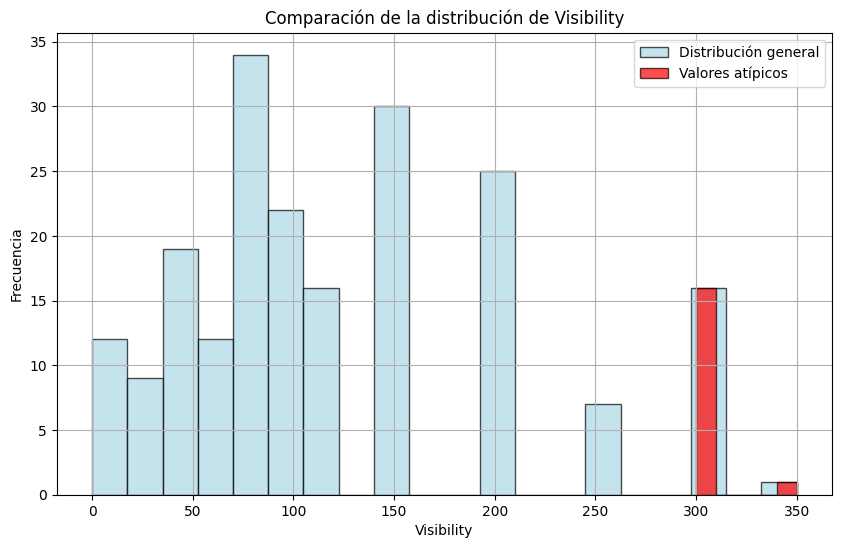

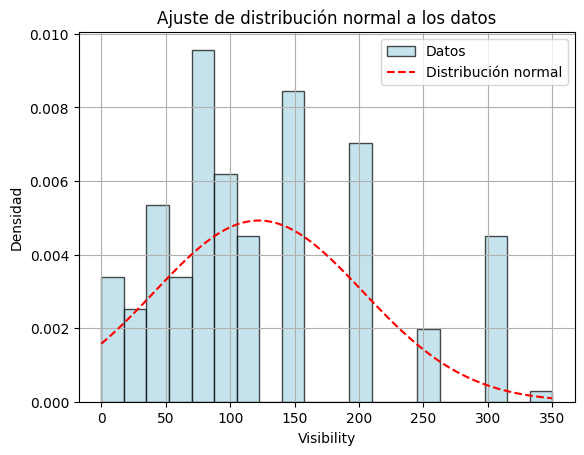

In [ ]:
# Comparar con la distribución general de Visibility
plt.figure(figsize=(10, 6))

# Histograma de Visibility
plt.hist(data['Visibility'], bins=20, color='lightblue', edgecolor='black', alpha=0.7, label='Distribución general')

# Marcar valores atípicos de Visibility
plt.hist(data.loc[indices_valores_atipicos_Visibility, 'Visibility'], bins=5, color='red', edgecolor='black', alpha=0.7, label='Valores atípicos')

plt.xlabel('Visibility')
plt.ylabel('Frecuencia')
plt.title('Comparación de la distribución de Visibility')
plt.legend()
plt.grid(True)
plt.show()

# Histograma de Visibility
plt.hist(data['Visibility'], bins=20, density=True, color='lightblue', edgecolor='black', alpha=0.7, label='Datos')

# Ajuste de distribución normal
mu, sigma = norm.fit(data['Visibility'])
x = np.linspace(min(data['Visibility']), max(data['Visibility']), 100)
pdf = norm.pdf(x, mu, sigma)
plt.plot(x, pdf, color='red', linestyle='--', label='Distribución normal')

plt.xlabel('Visibility')
plt.ylabel('Densidad')
plt.title('Ajuste de distribución normal a los datos')
plt.legend()
plt.grid(True)
plt.show()

Tras haber probado varias distribuciones, vemos que los datos no siguen del todo una distribución. Esto se debe a que no hay suficientes. Por ello, vamos a probar a analizar la media, la mediana y la varianza y así saber otras características de los outliers de Visibility.

In [ ]:
# Calcula estadísticas descriptivas
mean_visibility = np.mean(data['Visibility'])
median_visibility = np.median(data['Visibility'])
std_visibility = np.std(data['Visibility'])
percentiles_visibility = np.percentile(data['Visibility'], [25, 50, 75])

# Imprime los resultados
print("Media de Visibility:", mean_visibility)
print("Mediana de Visibility:", median_visibility)
print("Desviación estándar de Visibility:", std_visibility)
print("Percentiles de Visibility (25%, 50%, 75%):", percentiles_visibility)

Media de Visibility: 122.19704433497537
Mediana de Visibility: 100.0
Desviación estándar de Visibility: 80.97114118962236
Percentiles de Visibility (25%, 50%, 75%): [ 60. 100. 150.]


Se puede comprobar que los outliers están sesgando la media hacia la derecha, ya que casi todos tienen valor de 300 o más. Además, siendo la desviación estándar 81 aproximadamente, también es alta, probablemente por todos los outliers que la desvían hacia valores altos.

Por otro lado, se puede ver que en el último percentil (75%) están la mayoría de los datos, debido a la cantidad de outliers que tienden a valores altos, tiene sentido.

Los valores cuya visibility es de 300 no tienen valores parecidos en las demás variables. Es decir, no se caracterizan por una humedad y contaminación baja, por ejemplo. Por ello, no tienen que ser incorrectos, pero si están sesgando la distribución general de los datos.

Como no consideramos que sean incorrectos, lo que haremos será categorizarlos más adelante.

**2.- Estudiar la intersección y la unión de outliers entre las variables “Wind_speed” y “Visibility”**

Primero vamos a visualizar los outliers de Visibility y de Wind_speed por separado:

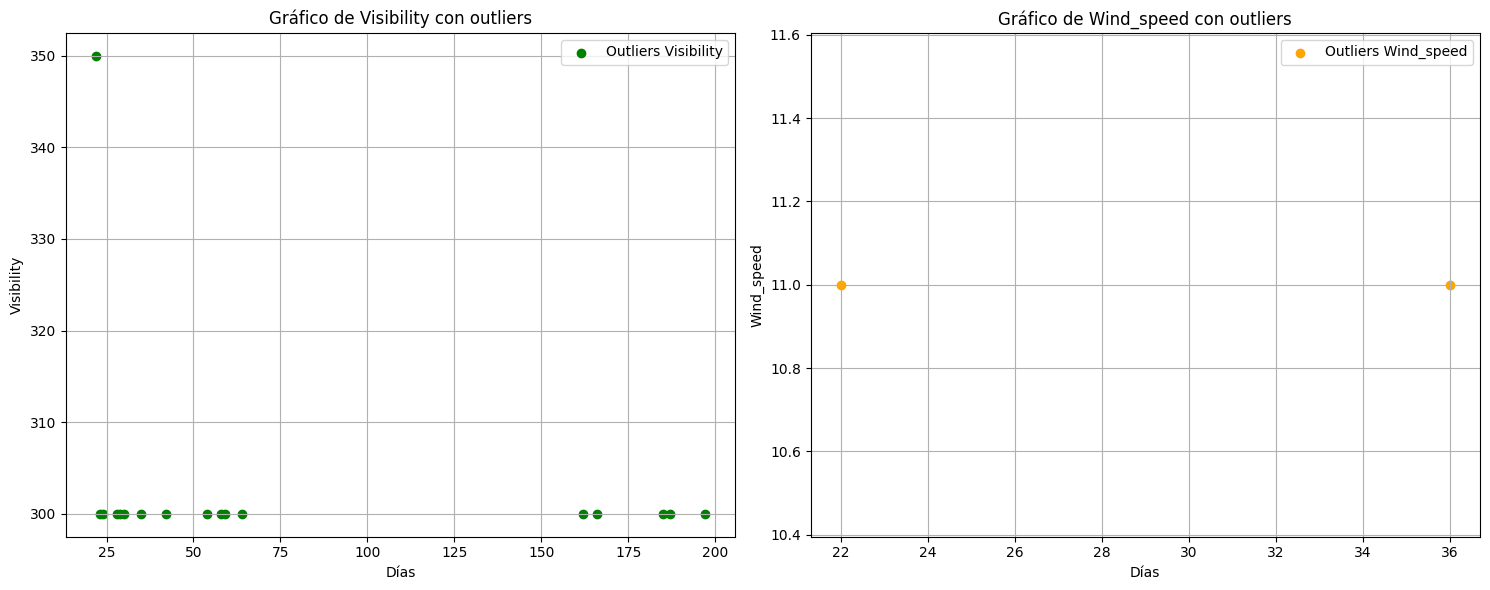

In [ ]:
# Crear una figura y dos subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Graficar Visibility en el primer subplot
axs[0].scatter(indices_valores_atipicos_Visibility, data['Visibility'].iloc[indices_valores_atipicos_Visibility], color='green', label='Outliers Visibility')
axs[0].set_xlabel('Días')
axs[0].set_ylabel('Visibility')
axs[0].set_title('Gráfico de Visibility con outliers')
axs[0].legend()
axs[0].grid(True)

# Graficar Wind_speed en el segundo subplot
axs[1].scatter(indices_valores_atipicos_wind_speed, data['Wind_speed'].iloc[indices_valores_atipicos_wind_speed], color='orange', label='Outliers Wind_speed')
axs[1].set_xlabel('Días')
axs[1].set_ylabel('Wind_speed')
axs[1].set_title('Gráfico de Wind_speed con outliers')
axs[1].legend()
axs[1].grid(True)

# Ajustar el espacio entre los subplots
plt.tight_layout()

# Mostrar los subplots
plt.show()

In [ ]:
# Unión de índices de valores atípicos de Wind_speed y Visibility
union_indices_atipicos = indices_valores_atipicos_wind_speed.union(indices_valores_atipicos_Visibility)

# Intersección de índices de valores atípicos de Wind_speed y Visibility
interseccion_indices_atipicos = indices_valores_atipicos_wind_speed.intersection(indices_valores_atipicos_Visibility)

# Mostrar las dimensiones de los conjuntos de datos de unión e intersección
print("Dimensiones de la unión de valores atípicos:", len(union_indices_atipicos))
print("Dimensiones de la intersección de valores atípicos:", len(interseccion_indices_atipicos))

Dimensiones de la unión de valores atípicos: 18
Dimensiones de la intersección de valores atípicos: 1


Por lo que se ve, no hay más de un valor en la intersección, lo que significa que solo hay un outlier que es el mismo en wind_speed y en visibility.

Ahora, vamos a visualizar la unión y la intersección de estas dos variables:

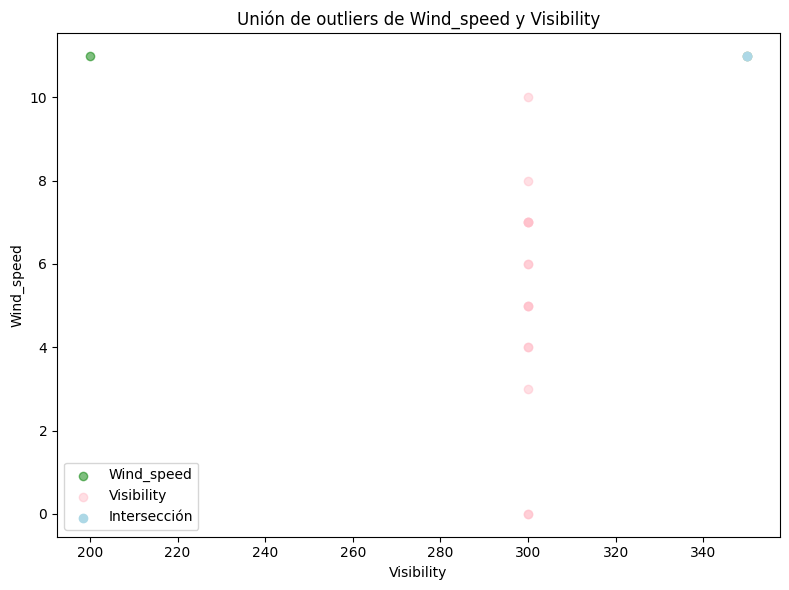

In [ ]:
# Crear una figura y ejes para subplots
fig, ax = plt.subplots(figsize=(8, 6))

# Graficar puntos que pertenecen a Wind_speed
ax.scatter(data.loc[indices_valores_atipicos_wind_speed, 'Visibility'], data.loc[indices_valores_atipicos_wind_speed, 'Wind_speed'], color='green', label='Wind_speed', alpha=0.5)

# Graficar puntos que pertenecen a Visibility
ax.scatter(data.loc[indices_valores_atipicos_Visibility, 'Visibility'], data.loc[indices_valores_atipicos_Visibility, 'Wind_speed'], color='pink', label='Visibility', alpha=0.5)

# Obtener intersección de los índices
interseccion_indices = indices_valores_atipicos_wind_speed.intersection(indices_valores_atipicos_Visibility)
indices_union = indices_valores_atipicos_wind_speed.union(indices_valores_atipicos_Visibility)

# Graficar puntos de intersección
ax.scatter(data.loc[interseccion_indices, 'Visibility'], data.loc[interseccion_indices, 'Wind_speed'], color='lightblue', label='Intersección')

# Configurar etiquetas y título
ax.set_xlabel('Visibility')
ax.set_ylabel('Wind_speed')
ax.set_title('Unión de outliers de Wind_speed y Visibility')
ax.legend()

plt.tight_layout()
plt.show()

Viendo la gráfica, comprobamos que los valores atípicos de Visibility se encuentran, casi todos, cuando esta tiene un valor de 300. Aunque, esto ya lo habíamos evaluado antes, aquí se comprueba gráficamente.

In [ ]:
# Obtener las filas correspondientes a la intersección de índices
filas_interseccion = data.iloc[interseccion_indices]

# Imprimir las filas de la intersección
print("Filas correspondientes a la intersección de índices:")
print(filas_interseccion)

Filas correspondientes a la intersección de índices:
    Month  Day_of_month  Day_of_week  ozone_reading  pressure_height  \
22      2             9            1           2.92             5490   

    Wind_speed  Humidity  Temperature_Sandburg  Temperature_ElMonte  \
22          11        72                    37                38.48   

    Inversion_base_height  Pressure_gradient  Inversion_temperature  \
22                   5000                 32                  38.12   

    Visibility  
22         350  


El dato que es outlier tanto para visibility como para wind_speed es el 22. Este resulta ser el de valores más extremos de viento y de visibilidad con baja temperatura.

**3.- Categoriza algunas de las variables y lleva a cabo representaciones que nos permitan
relacionar diferentes variables ¿Qué nos dicen los datos?**


A la hora de decidir qué par de variables serían de utilidad para categorizar, lo primero que debemos hacer es un estudio de cómo son las variables que tenemos, si ya son categóricas o no, y qué representan.

Las tres primeras variables `Month`, `Day_of_month`, `Day_of_week` no nos compensa categorizarlas más o de otra forma; `Month` y `Day_of_week` ya están categorizadas, los meses de 1 a 12 (enero a febrero) y los días de la semana de 1 a 5 (lunes a viernes). Más adelante nos compensará crear una nueva variable llamada `Date` para ver la evolución de algunas variables con respecto al tiempo.

En base al nombre de las variables y al objeto de estudio, la primera variable que nos interesaría categorizar es `Wind_speed`. Veamos que forma tiene.



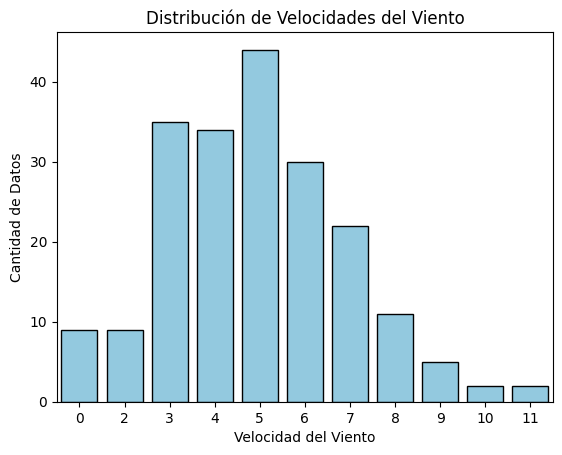

In [ ]:
# Crear el gráfico de barras de la distribución de valores
sns.countplot(x='Wind_speed', data=data, color='skyblue', edgecolor='black')

# Añadir etiquetas al gráfico
plt.xlabel('Velocidad del Viento')
plt.ylabel('Cantidad de Datos')
plt.title('Distribución de Velocidades del Viento')

# Mostrar el gráfico
plt.show()

Echando un breve vistazo a la representación de los datos e investigando la forma de estos, descubrimos que la variable `Wind_speed` ya está catgorizada, pues está representada en la escala de Beaufort, la cual consta de valores del 0 al 12 en el que cada valor indica un tipo de viento, en base a unas condiciones y características. Esta escala fue establecida con propósitos navales pero se ha ido adaptando con el tiempo. A continuación podemos observar la clasificación de esta escala de manera más detallada. [3]


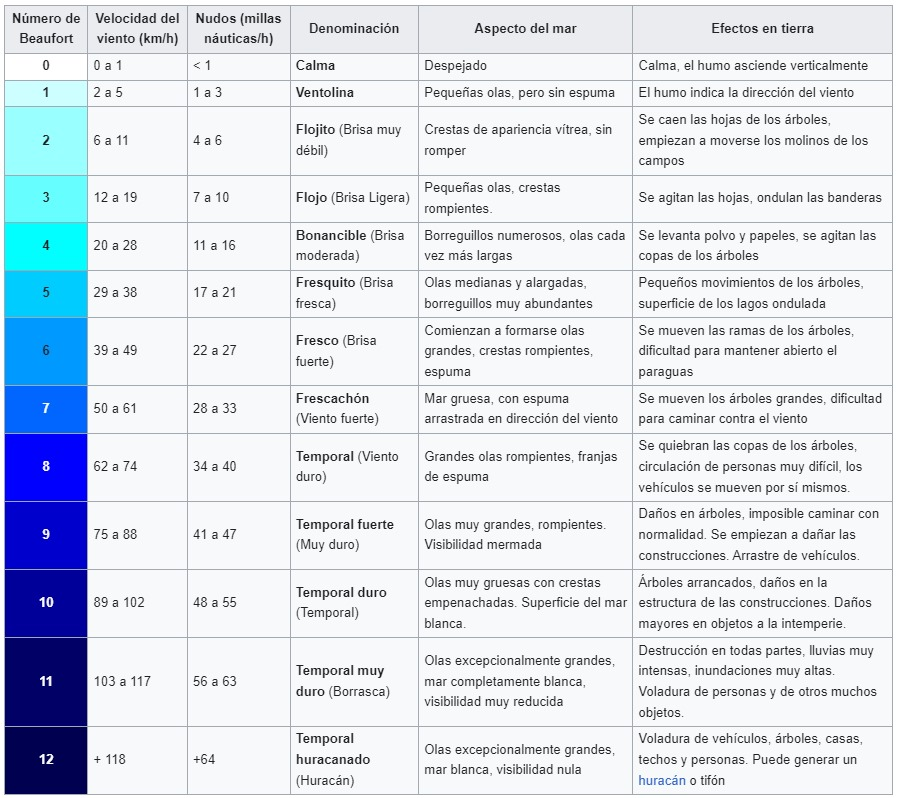

Teniendo en cuenta el resto de variables, y pensando cuales pueden resultar más útiles de categorizar teniendo en cuenta el objeto de estudio, deducimos que las variables que vamos a categorizar son `Visibility` y `Humidity`.




**Categorizando la variable Visibility.**

Lo primero que debemos hacer para poder categorizar correctamente nuestra variable es obtener los valores máximos y mínimos de la variable, y en base a eso y a que no se dispone información sobre la variable, se investigará un poco para generar las categorías más apropiadas posibles.

In [ ]:
# Obtener el máximo y el mínimo de 'Visibility'
max_visibility = data['Visibility'].max()
min_visibility = data['Visibility'].min()

# Mostrar los resultados
print(f"Máximo valor de 'visibility': {max_visibility}")
print(f"Mínimo valor de 'visibility': {min_visibility}")

Máximo valor de 'visibility': 350
Mínimo valor de 'visibility': 0


Calculando su valor máximo y mínimo obtenemos 350 y 0 respectivamente. En base a esto se hacen ciertas suposiciones que nos ayuden a la tarea de categorizar la variable de la forma más 'real' posible.

Se intuye que la variable hace referencia a la visibilidad atmosférica, lo que estaría relacionado con la claridad o transparencia del aire. Esto sería relevante en la evaluación de la calidad de aire y la presencia de contaminantes como el ozono, motivo por el que a continuación estudiaremos la relación entre ambas variables.

En base a los valores máximos y mínimos, suponemos que la variable indica la cantidad de metros que son visibles desde el punto donde se encuentra el sensor. Teniendo esto en cuenta estableceremos unas categorias que se ajusten a las que utilizan instituciones como la DGT. [4]

En este caso en concreto no es primordial que las categorías estén equilibridas en base al número de observaciones, porque esto podría alterar los valores que se limitan cada categoría y no llegar a formar parte de un contexto real.


Estableceremos las siguientes categorías:

* Baja visibilidad (0 - 65)
* Moderada visibilidad (66 - 120)
* Buena visibilidad (121 - 250)
* Excelente visibilidad (251 - 350)

In [ ]:
# Crear las categorías y los límites
categorias_visibility = ['Baja', 'Moderada', 'Buena', 'Excelente']
limites_visibility = [0, 66, 120, 250, 351]

# Utilizar pd.cut para asignar las categorías
data['Visibility_category'] = pd.cut(data['Visibility'], bins=limites_visibility, labels=categorias_visibility, right=False)

# Imprimir el DataFrame con las nuevas categorías
print(data[['Visibility', 'Visibility_category']])

     Visibility Visibility_category
0            60                Baja
1            60                Baja
2           100            Moderada
3           250           Excelente
4           120               Buena
..          ...                 ...
198         100            Moderada
199         200               Buena
200          70            Moderada
201          40                Baja
202         100            Moderada

[203 rows x 2 columns]


Una vez ya tenemos categorizada la variable `Visibility` vamos a pasar a estudiarla con respecto a la variable `ozone_reading`'.

Podemos establecer que una visibilidad más baja podría indicar una mayor concentración de partículas en el aire, lo que podría estar relacionado con la presencia de ozono o no, pues también se podría dar por condiciones climatológicas especiales. Y por ello estudiraremos la relación que existe entre estas dos variables.

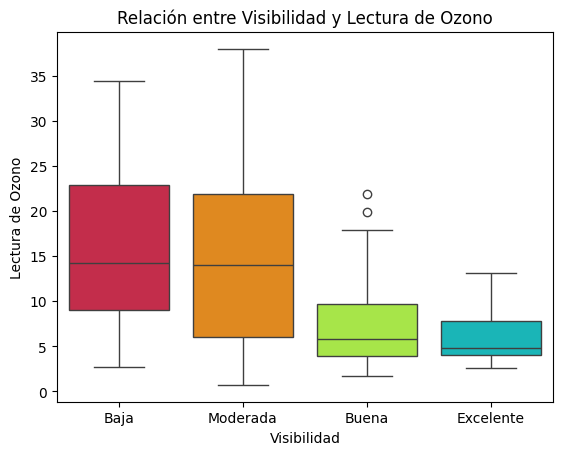

In [ ]:
# Suprimir las advertencias
warnings.filterwarnings("ignore")

# Define un diccionario de colores para cada categoría de visibilidad
colors = {'Excelente': 'darkturquoise', 'Buena': 'greenyellow', 'Moderada': 'darkorange', 'Baja': 'crimson'}

# Representamos la relación entre las categorías establecidas en la variable visibilidad y 'ozone_reading'
sns.boxplot(x='Visibility_category', y='ozone_reading', data=data, palette=colors)

# Añade etiquetas y título al gráfico
plt.title('Relación entre Visibilidad y Lectura de Ozono')
plt.xlabel('Visibilidad')
plt.ylabel('Lectura de Ozono')

# Muestra el gráfico
plt.show()

Las conclusiones principales que podemos sacar observando este gráfico son que cuando la visibilidad es buena o excelente, los niveles de ozono son relativamente bajos; sin embargo, cuando la visibilidad es baja o moderada no podemos determinar nada muy específico.

En este caso, cuando existe una visibilidad moderada encontramos que los valores del ozono están más dispersos, encontrandose en este rango tanto el máximo como el mínimo. Esto se podría explicar con las condiciones climatológicas porque la contaminación no es lo único que impide que haya una buena visibilidad, un ejemplo de un día de mala visibilidad puede ser un día con niebla, y el hecho de que haya niebla, no sabemos ciertamente qué efecto tiene con respecto a la presencia de ozono.

En conclusión, una buena visibilidad asegura niveles bajos de ozono, pero una mala visibilidad no es algo determinante para intuir el nivel de ozono en el ambiente.

**Categorizando la variable Humidity.**

Como en el caso anterior, lo primero que debemos hacer para poder categorizar correctamente nuestra variable es obtener los valores máximos y mínimos de la variable, y en base a eso y a que no se dispone información sobre la variable, se investigará un poco para generar las categorías más apropiadas posibles.

In [ ]:
# Obtener el máximo y el mínimo de 'Humidity'
max_humidity = data['Humidity'].max()
min_humidity = data['Humidity'].min()

# Mostrar los resultados
print(f"Máximo valor de 'Humidity': {max_humidity}")
print(f"Mínimo valor de 'Humidity': {min_humidity}")

Máximo valor de 'Humidity': 93
Mínimo valor de 'Humidity': 19


Calculando su valor máximo y mínimo obtenemos 93 y 19 respectivamente. Teniendo en cuenta estos valores y un poco de conocimiento general, suponemos que la húmedad está medida en porcentaje, por lo que hablariamos de la humedad relativa.

A continuación, estableceremos las categorías. Cuesta mucho encontrar un criterio único para categorizar la humedad relativa, pues afectan diferentes factores como si se trata de un lugar interior o exterior, la temperatura del ambiente...

Sin embargo, podemos suponer un criterio aproximado en base a la información encontrada [5], que sería el siguiente:
* Baja (0% - 30%)
* Buena (31% - 70%)
* Alta (71% - 100%)


In [ ]:
# Crear las categorías y los límites
categorias_humidity = ['Baja', 'Buena', 'Alta']
limites_humidity = [0, 30, 70, 100]

# Utilizar pd.cut para asignar las categorías
data['Humidity_category'] = pd.cut(data['Humidity'], bins=limites_humidity, labels=categorias_humidity, right=False)

# Imprimir el DataFrame con las nuevas categorías
print(data[['Humidity', 'Humidity_category']])

     Humidity Humidity_category
0          51             Buena
1          69             Buena
2          19              Baja
3          25              Baja
4          73              Alta
..        ...               ...
198        57             Buena
199        53             Buena
200        23              Baja
201        61             Buena
202        85              Alta

[203 rows x 2 columns]


Como en el caso anterior, las categorías no tienen que ser necesariamente de las mismas dimensaiones en cuanto al tema de observaciones, pues hablamos de medidas con un criterio 'universal', que no se deben ajustar a nuestra base en específico.

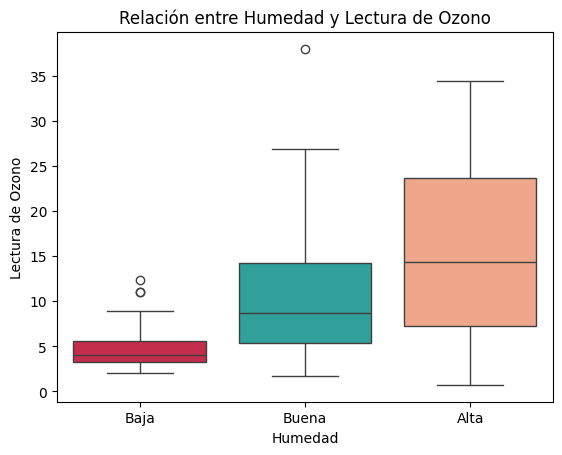

In [ ]:
# Suprimir las advertencias
warnings.filterwarnings("ignore")

# Define un diccionario de colores para cada categoría de visibilidad
colors = {'Buena': 'lightseagreen', 'Alta': 'lightsalmon', 'Baja': 'crimson'}

# Representamos la relación entre las categorías establecidas en la variable 'Humidity'' y 'ozone_reading'
sns.boxplot(x='Humidity_category', y='ozone_reading', data=data, palette=colors)

# Añade etiquetas y título al gráfico
plt.title('Relación entre Humedad y Lectura de Ozono')
plt.xlabel('Humedad')
plt.ylabel('Lectura de Ozono')

# Muestra el gráfico
plt.show()

Las conclusiones principales que podemos sacar observando este gráfico son que cuando la humedad es baja, los niveles de ozono también lo son.

Cuando los niveles de humedad son los más aceptables (buena) tenemos un alto rango de medidas del ozono, y bien es cierto, que el valor máximo de la presencia de ozono se presenta en esta categoría, también podemos observar en base a la media y al tamaño de los cuartiles y de los bigotes, que hay más observaciones en la parte más baja de la gráfica, determinando que el 75% de los datos que se recolectaron cuando los niveles de humedad eran los mejores, los niveles de ozono son bajos (menores de 15).

En último lugar, cuando la humedad es alta, la presencia de ozono, en general, también aumenta, aunque como ha pasado con el caso de Visibility, el rango es tan amplio, que simplemente el hecho aislado de que un día haya niveles de humedad muy altos no es suficiente como para afirmar que ese día el nivel de ozono va a ser elevado.


**4.- Se desea saber cómo se distribuyen y cuáles son las frecuencias de las principales variables
respecto a los días de medición. Lleva a cabo la representación más útil (sólo una). Justificar la respuesta.**

Para ver qué variables seleccionaremos como las principales representaremos la matriz de correlaciones y cogeremos aquellas que más correlación tengan con la variable `ozone_reading`, la cual hemos establecido como la variable de estudio. Seleccionar variables basándose en la matriz de correlaciones implica identificar aquellas que tienen una relación lineal fuerte con la variable de interés, al centrarse encreducir la multicolinealidad y crear modelos más simples e interpretables.

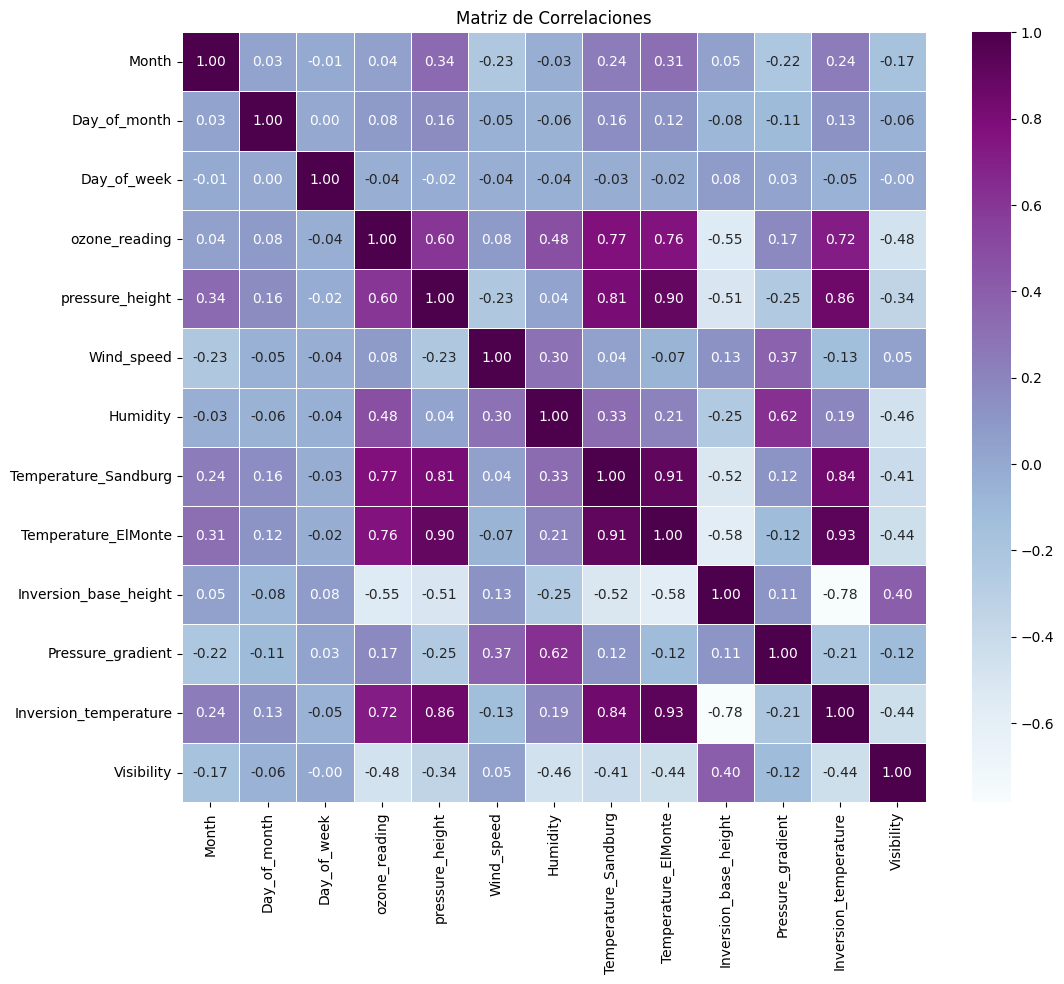

In [ ]:
# Calcular la matriz de correlaciones de todas las variables del Dataset
correlation_matrix = data.corr()

# Crear un mapa de calor con seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='BuPu', fmt='.2f', linewidths=.5)

# Añadir título
plt.title('Matriz de Correlaciones')

# Mostrar el mapa de calor
plt.show()

Teniendo en cuenta la matriz de correlaciones y el tema de estudio, podemos afirmar que las variables principales, de las cuales nos interesa representar y medir su frecuencia son: `ozone_reading`, `pressure_height`, `Inversion_temperature`, `Temperature_ElMonte` y `Temperature_Sandburg`, pues todas están relacionadas con la variable `ozone_reading` con un coeficiente mayor al 0'5.


En todas las variables estudiaremos dos gráficas, en la primera veremos la evolución de la variable en concreto a lo largo del año, como de esta gráfica no se pueden sacar muy en claro la distribución y la frecuencia de la variable, representaremos un histograma a continuación.

Empezamos estudiando la variable principal **`ozone_reading`**

Esta variable mide la cantidad de ozono que hay presente en la atmosfera en el momento en el que se realiza la medición.

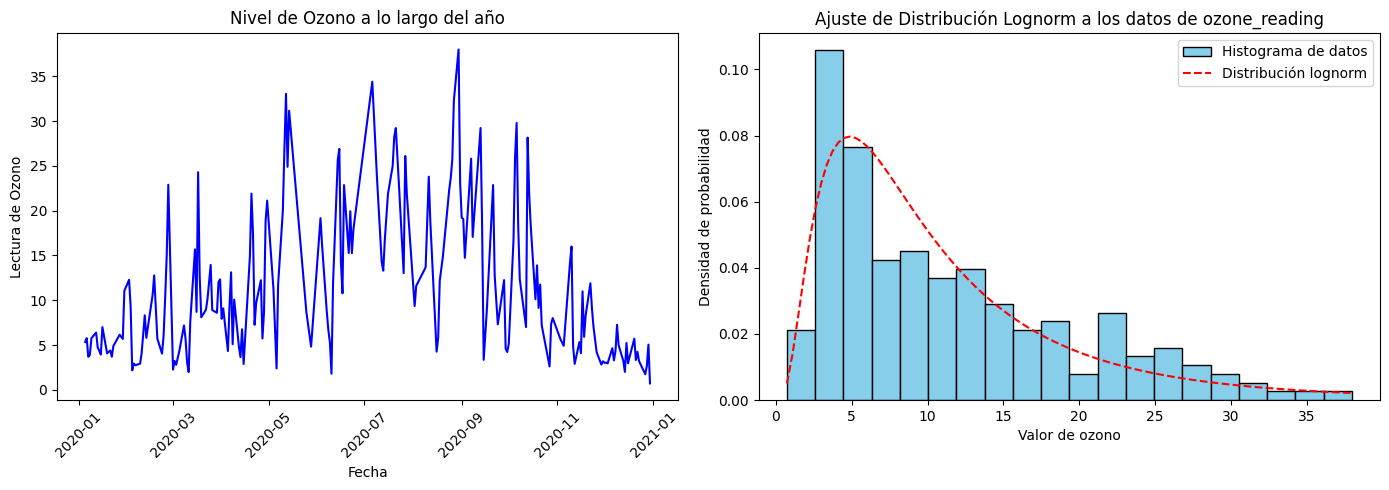

In [ ]:
# Crear una nueva columna 'date' concatenando 'month' y 'day_of_month' para ver la evolución a lo largo del año
data['date'] = pd.to_datetime(data[['Month', 'Day_of_month']].astype(str).agg('-'.join, axis=1) + '-2020', format='%m-%d-%Y')

# Ordenar el DataFrame por la columna 'date'
dataclass_transform = data.sort_values('date')

# Crear el gráfico de líneas
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(data['date'], data['ozone_reading'], linestyle='-', color='b')

# Añadir etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Lectura de Ozono')
plt.title('Nivel de Ozono a lo largo del año')

# Rotar las etiquetas del eje x para una mejor visualización
plt.xticks(rotation=45)

# Crear histograma de frecuencias
plt.subplot(1, 2, 2)

# Ajuste de distribución lognorm
shape, loc, scale = lognorm.fit(data['ozone_reading'])
x = np.linspace(min(data['ozone_reading']), max(data['ozone_reading']), 100)
pdf = lognorm.pdf(x, shape, loc=loc, scale=scale)

# Histograma
plt.hist(data['ozone_reading'], bins=20, color='skyblue', edgecolor='black', density=True, label='Histograma de datos')

# Dibujamos la distribución lognorm
plt.plot(x, pdf, color='red', linestyle='--', label='Distribución lognorm')

plt.legend()
plt.xlabel('Valor de ozono')
plt.ylabel('Densidad de probabilidad')
plt.title('Ajuste de Distribución Lognorm a los datos de ozone_reading')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

El primer gráfico muestra como el nivel de ozono de cada día a lo largo del año, visto así es muy dificil analizar tendencias, frecuencias y qué distribución sigue. Por este motivo, hemos decidido representar los datos en forma de histograma, como se muestra en el segundo gráfico.

Observando el segundo gráfico, vemos que se encuentra desplazado hacia la izquierda, lo que indica que la mayoría de las observaciones de la variable `ozone_reading` hacen referencia a niveles de ozono relativamente bajos (menores al valor 15) y que la tendencia según los niveles de ozono van aumentando, va siendo cada vez más baja.

También es destacable que en ningún momento del año no hay presencia absoluta de ozono (`ozone_reading` = 0).

Ahora analizaremos la variable **`Pressure_height`**

Esta variable en nuestra base de datos hace se refiere a la presión atmosférica medida a diferentes alturas. En estudios atmosféricos y climatológicos, la presión atmosférica puede variar con la altitud, y esta variación es crucial para comprender la distribución y comportamiento de diversos componentes atmosféricos, en nuestro caso, el ozono.

La presión atmosférica disminuye con la altitud, y las mediciones de ozono a diferentes alturas pueden proporcionar información sobre la distribución vertical del ozono en la atmósfera.

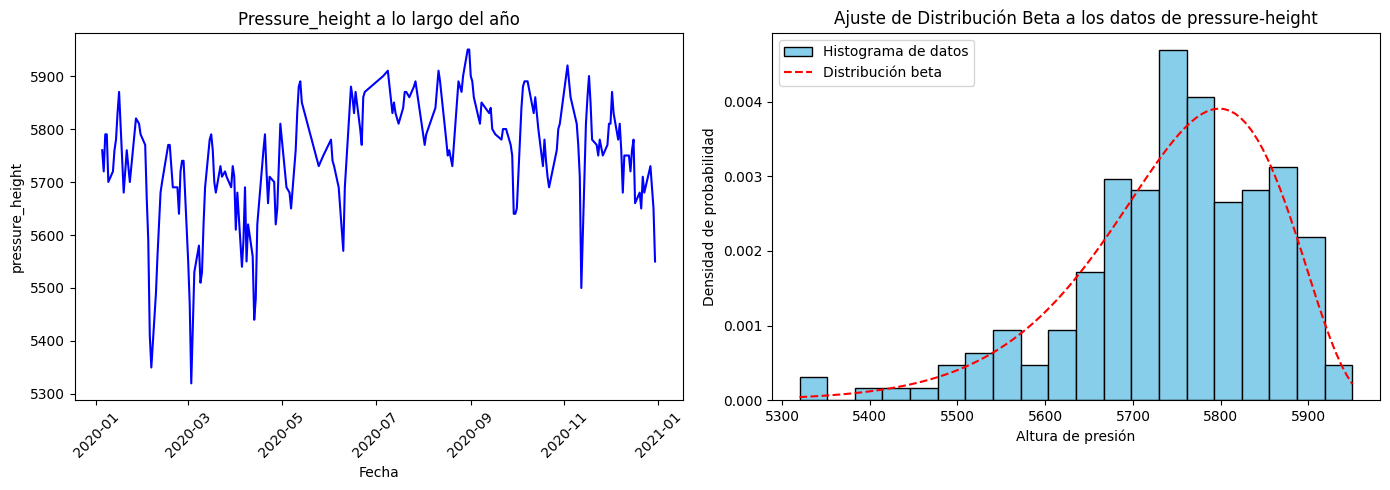

In [ ]:
# Crear el gráfico de líneas
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(data['date'], data['pressure_height'], linestyle='-', color='b')

# Añadir etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('pressure_height')
plt.title('Pressure_height a lo largo del año')

# Rotar las etiquetas del eje x para una mejor visualización
plt.xticks(rotation=45)

# Crear histograma de frecuencias
plt.subplot(1, 2, 2)

# Suprimir las advertencias
warnings.filterwarnings("ignore")

# Ajuste de distribución beta
a, b, loc, scale = beta.fit(data['pressure_height'])
x = np.linspace(min(data['pressure_height']), max(data['pressure_height']), 100)
pdf = beta.pdf(x, a, b, loc=loc, scale=scale)

# Histograma
plt.hist(data['pressure_height'], bins=20, color='skyblue', edgecolor='black', density=True, label='Histograma de datos')

# Distribución beta
plt.plot(x, pdf, color='red', linestyle='--', label='Distribución beta')

plt.legend()
plt.xlabel('Altura de presión')
plt.ylabel('Densidad de probabilidad')
plt.title('Ajuste de Distribución Beta a los datos de pressure-height')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

En este caso, podemos sacar más información del gráfico de líneas que del histograma.

Podemos ver que en general los valores se mantienen aproximadamente en la misma franja (5600 - 6000), y que los outliers ocurren de vez en cuando, de manera muy exagerada, como se puede observar en los picos más pronunciados de la gráfica de la evolución con respecto al tiempo.

Ahora analizaremos la variable **`Inversion_temperature`**

La inversión térmica se presenta cuando la temperatura del aire, en lugar de seguir la tendencia habitual de disminuir con la altitud, aumenta progresivamente. Este fenómeno puede dar lugar a la retención de contaminantes atmosféricos cerca del suelo, generando impactos perjudiciales para la salud.

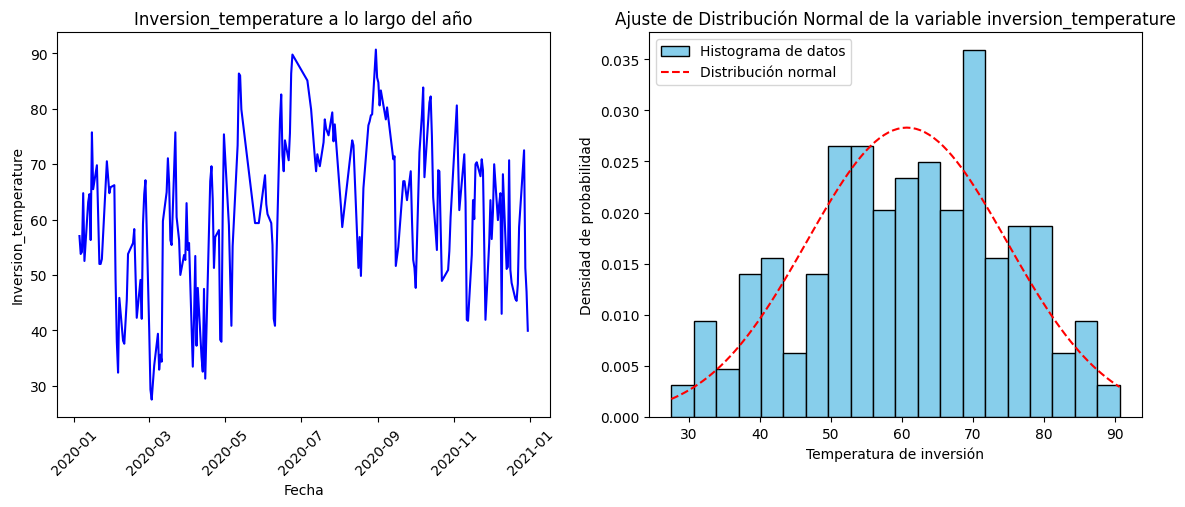

In [ ]:
# Crear el gráfico de líneas
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(data['date'], data['Inversion_temperature'], linestyle='-', color='b')

# Añadir etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Inversion_temperature')
plt.title('Inversion_temperature a lo largo del año')

# Rotar las etiquetas del eje x para una mejor visualización
plt.xticks(rotation=45)

# Crear histograma de frecuencias
plt.subplot(1, 2, 2)

# Ajuste de distribución normal
mu, sigma = norm.fit(data['Inversion_temperature'])
x = np.linspace(min(data['Inversion_temperature']), max(data['Inversion_temperature']), 100)
pdf = norm.pdf(x, mu, sigma)

# Histograma
plt.hist(data['Inversion_temperature'], bins=20, color='skyblue', edgecolor='black', density=True, label='Histograma de datos')

# Distribución normal
plt.plot(x, pdf, color='red', linestyle='--', label='Distribución normal')

plt.legend()
plt.xlabel('Temperatura de inversión')
plt.ylabel('Densidad de probabilidad')
plt.title('Ajuste de Distribución Normal de la variable inversion_temperature')
plt.show()


En el análisis del conjunto de las gráficas de la variable `inversion_temperature`, se destaca que la distribución principal se encuentra entre 50 y 60 grados, y se ha registrado una leve tendencia descendente en el último año.

Como ya se ha explicado, la temperatura de inversión es un fenómeno meteorológico donde una capa de aire caliente se sitúa sobre una capa de aire frío, lo que puede resultar en la retención de aire frío con potenciales efectos negativos en la calidad del aire y la salud humana. La tendencia descendente podría indicar la influencia del cambio climático en el clima.

Se observan un par de valores atípicos, esto puede deberse a posibles errores en las mediciones o eventos climáticos excepcionales.



Por último, veremos qué pasa con las **temperaturas**

En este caso, aunque por la matriz de correlaciones nos sale que las temperaturas están muy relacionadas con nuestra variable principal 'ozone_reading' no las vamos a estudiar en profundidad, debido a que no son temperaturas que se ajusten al contexto del problema. *El Monte* y *Sandbur*, los lugares que indican los nombres de ambas variables no se encuentran situados en las proximidades de la **Universidad Francisco de Vitoria**. Además ambas se distribuyen de una manera bastante parecida a la variable `inversion_temperature`, que es una variables, que en este contexto, nos aporta mayor información.

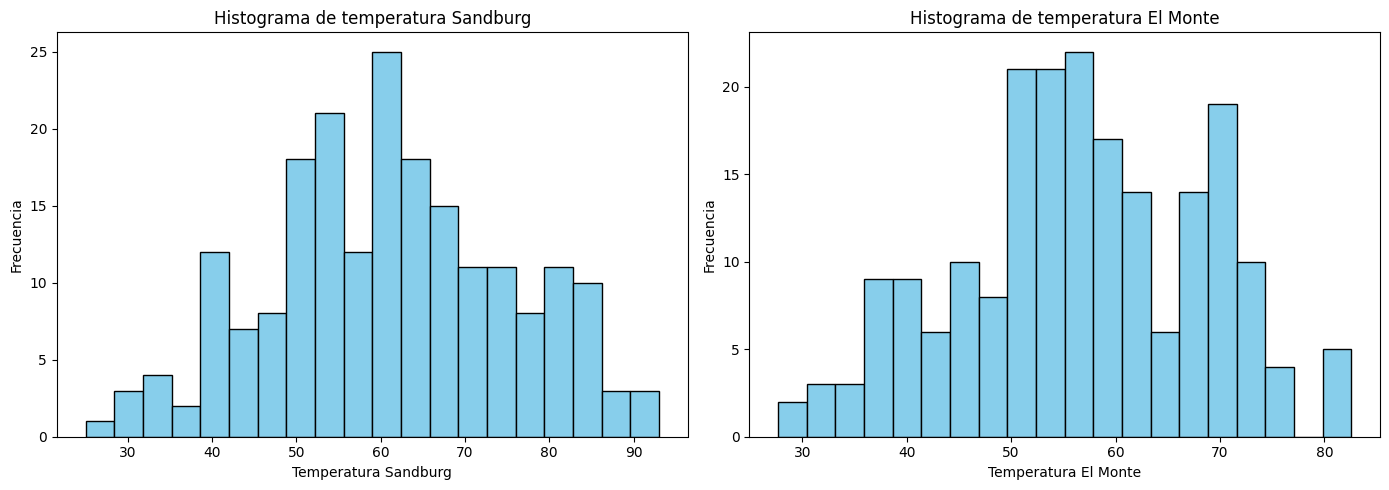

In [ ]:
# Crear el gráfico de líneas
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.hist(data['Temperature_Sandburg'], bins=20, color='skyblue', edgecolor='black')

# Añadir etiquetas y título
plt.xlabel('Temperatura Sandburg')
plt.ylabel('Frecuencia')
plt.title('Histograma de temperatura Sandburg')

# Crear histograma de frecuencias
plt.subplot(1, 2, 2)
plt.hist(data['Temperature_ElMonte'], bins=20, color='skyblue', edgecolor='black')

# Añadir etiquetas y título
plt.xlabel('Temperatura El Monte')
plt.ylabel('Frecuencia')
plt.title('Histograma de temperatura El Monte')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

## Práctica 3: Reducción de la dimensionalidad

### Acceso al archivo de trabajo

A continuación, se acceden a los datos contenidos en el archivo Excel de origen a través de su ruta de acceso, y se visualiza el DataFrame con el objetivo de conocer su contenido y comprender el objeto de estudio de estos.

In [ ]:
file_path = 'USA.xlsx'

# Guarda el archivo Excel en el DataFrame
df_original = pd.read_excel(file_path)

# Visualización inicial
df_original.head()

,Ciudad,SO2,Neg.Temp,Empresas,Poblacion,Viento,Precip,Dias
0,Phoenix,10.0,70.3,213.0,582.0,6.0,7.05,36.0
1,Little Rock,13.0,61.0,91.0,132.0,8.2,48.52,100.0
2,San Francisco,12.0,56.7,453.0,716.0,8.7,20.66,67.0
3,Denver,17.0,51.9,454.0,515.0,9.0,12.95,86.0
4,Hartford,56.0,49.1,412.0,158.0,9.0,43.37,127.0


### Dominio de aplicación

Se observa que la información contenida en el documento se relaciona con indicadores demográficos, económicos y climáticos de algunas de las ciudades más importantes de los Estados Unidos. Para conocerlos mejor, se procede a la **explicación de las variables** que definen la base de datos.

* **SO2**: Concentración de dióxido de azufre en el aire. De acuerdo a los valores observados en el histórico, se concluye que las mediciones se han hecho en partes por mil millones (*ppb*) [6].

* **Neg. Temp**: Temperatura media medida en grados Fahrenheit (*°F*).

* **Empresas**: Número de empresas grandes y medianas en la ciudad.

* **Poblacion**: Número de miles de habitantes en una ciudad.

* **Viento**: Velocidad media del viento en millas por hora (*mi/h*).

* **Precip**: Precipitación media anual.

* **Dias**: Días en los que ha llovido en el curso de un año.

El presente documento tiene como finalidad el estudio de la correlación entre variables, así como la clasificación y análisis de las ciudades objeto en función de esta. No obstante, de entre la totalidad de las variables de estudio, destaca el parámetro ***SO2***. El dióxido de azufre es un gas generado en los procesos de combustión cuya presencia en la atmósfera genera un impacto en la salud de las comunidades. Por lo tanto, el análisis de las poblaciones que muestran niveles relativamente altos a través de otros indicadores como los especificados en la tabla podría esclarecer el perfil de las ciudades donde la nocividad de este gas en la salud de sus habitantes sea más alarmante.



### Estudio estadístico de las variables

A partir del DataFrame inicial de datos que se ha mostrado al comienzo, se ha podido percibir una variabilidad en los indicadores bastante alta entre las distintas ciudades examinadas. Por ello, se considera importante hacer un primer estudio estadístico sobre los datos para conocer su naturaleza, así como los valores esperados y casos atípicos cuyo estudio pueda ser relevante.

Para el resumen estadístico, se tendrán en cuenta todos los indicadores a excepción de la variable *Ciudad*, cuyo contenido no resulta significativo para el análisis.

In [ ]:
print(df_original.dtypes)

Ciudad        object
SO2          float64
Neg.Temp     float64
Empresas     float64
Poblacion    float64
Viento       float64
Precip       float64
Dias         float64
dtype: object


Todos los indicadores previamente mencionados se corresponden con variables de tipo numérico. Luego el análisis resultante contendrá información como la media, mediana o los cuartiles, entre otros. A partir del conocimiento que la desviación estándar proporciona, se observa que indicadores como la actividad empresarial o el número de habitantes muestran mayor variabilidad en sus datos; en primera instancia, los núcleos poblacionales pueden resultar de especial interés para el estudio de estas características y la forma de relacionarse con los indicadores restantes.

In [ ]:
# Se seleccionan las columnas de valores numéricos
numeric_columns = df_original.select_dtypes(include=['float64']).columns

# Resumen estadístico, omitiendo la fila de número de observaciones
resumen_estadistico = df_original[numeric_columns].describe().drop('count')

# Se cambian el formato de texto para facilitar la lectura de la tabla
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print(resumen_estadistico)

        SO2  Neg.Temp  Empresas  Poblacion  Viento  Precip   Dias
mean  30.05     55.76    463.10     608.61    9.44   36.77 113.90
std   23.47      7.23    563.47     579.11    1.43   11.77  26.51
min    8.00     43.50     35.00      71.00    6.00    7.05  36.00
25%   13.00     50.60    181.00     299.00    8.70   30.96 103.00
50%   26.00     54.60    347.00     515.00    9.30   38.74 115.00
75%   35.00     59.30    462.00     717.00   10.60   43.11 128.00
max  110.00     75.50   3344.00    3369.00   12.70   59.80 166.00


Para comprender mejor la información reflejada en los parámetros estadísticos previos, se procede a la representación gráfica de la información mediante Diagramas de Caja. Estas figuras permiten resumir los cuartiles, así como la mediana de cada variable y los datos atípicos o *outliers* que se puedan encontrar.

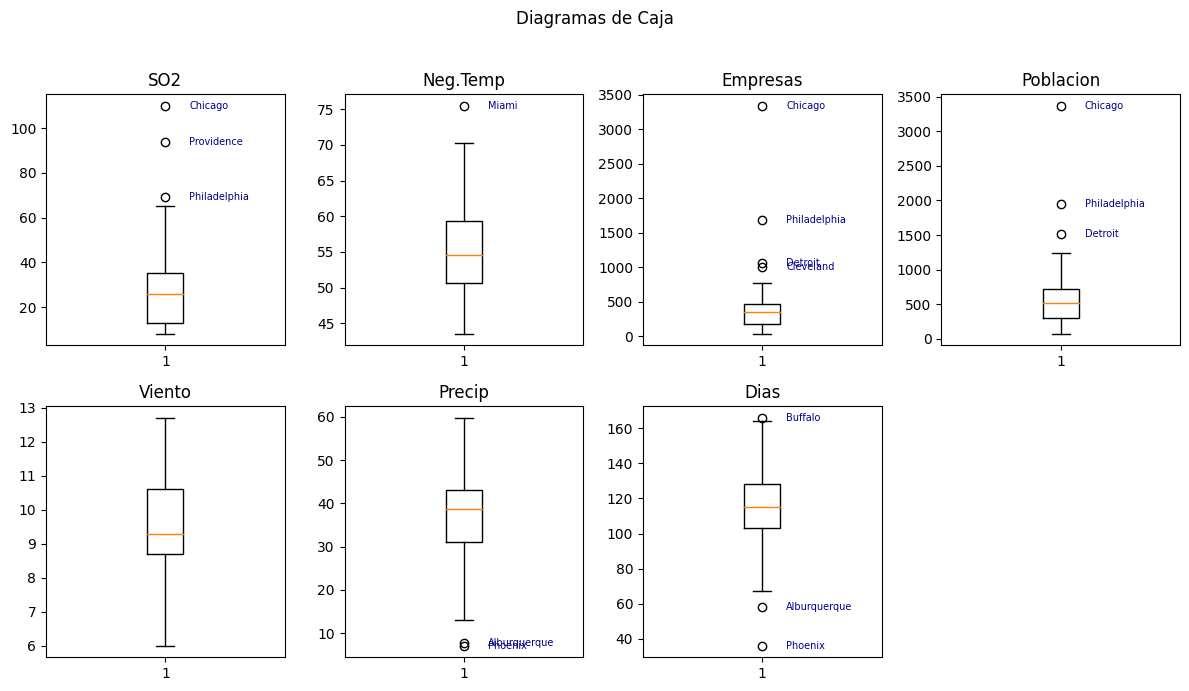

In [ ]:
# Se muestran los diagramas en filas de cuatro
num_columns = 4
num_rows = int(np.ceil(len(numeric_columns) / num_columns))

fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 7))
fig.suptitle('Diagramas de Caja')
axes = axes.flatten()

# Boxplot de cada variable
for i, column in enumerate(numeric_columns):

    ax = axes[i]
    box = ax.boxplot(df_original[column])
    ax.set_title(column)

    # Etiquetamos los outliers
    outliers = [flier.get_ydata() for flier in box["fliers"]]
    outliers_cities = df_original.loc[df_original[column].isin(outliers[0]),
                                      'Ciudad']
    for city in outliers_cities:
        ax.text(1.1, df_original.loc[df_original['Ciudad'] == city, column].values[0],
                city, color='darkblue', fontsize=7, ha='left', va='center')


# Borramos las gráficas que se han creado vacías
for i in range(len(numeric_columns), num_rows * num_columns):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

En relación con los resultados obtenidos, se aprecia que una de las ciudades más alejadas del comportamiento común es Chicago, que presenta el máximo en emisiones de dióxido de azufre al igual que en confluencia de empresas y densidad poblacional. Asimismo, Alburquerque y Phoenix se distancian del resto de observaciones para los indicadores relacionados con las condiciones de precipitación, mostrando un clima bastante seco. No obstante, se evaluarán en mayor profundidad a lo largo del documento.

Como se ha mencionado previamente, el objetivo del siguiente análisis es el de comprender las relaciones existentes entre indicadores y sus consecuencias en la situación medioambiental. Para ello, se recurrirá a técnicas de reducción de la dimensionalidad del espacio. Mediante estas herramientas, se logra sintetizar la información original así como extraer las interconexiones presentes entre las distintas variables de estudio.

### Estudio de la covarianza

La matriz de covarianza estudia la relación lineal entre las diferentes variables de estudio. Así, esta herramienta logra informar sobre la forma en que diferentes pares de características cambian juntas al igual que el sentido de su interconexión (directa o inversa).

#### Estandarización de los datos

**1.- Lo primero que habrá que hacer será estandarizar los datos para que las diferencias de rango no supongan un problema a la hora de procesar la información. Usa para ello el método StandardScaler de la librería scikit-learn.**

De acuerdo con la información disponible en la base de datos de estudio, se conoce que todas las variables de estudio, a excepción de los nombres de las ciudades, contienen información de tipo ***float64***. A continuación, se creará un nuevo DataFrame que contenga los datos numéricos estandarizados. Este proceso favorece el tratamiento de los datos, que tomarán valores en una misma escala de media cero y desviación estándar de uno. Asimismo, será de utilidad para las herramientas computacionales en el estudio posterior de las correlaciones entre indicadores. Concretamente, las características numéricas serán factibles para la computación de la matriz de covarianza.

In [ ]:
# Estandarización
scaler = StandardScaler()
df = df_original.copy()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

pd.reset_option('display.float_format')
df.head()

,Ciudad,SO2,Neg.Temp,Empresas,Poblacion,Viento,Precip,Dias
0,Phoenix,-0.864758,2.036213,-0.449363,-0.046520,-2.440555,-2.556012,-2.975514
1,Little Rock,-0.735360,0.733515,-0.668567,-0.833224,-0.881504,1.010653,-0.531009
2,San Francisco,-0.778493,0.131192,-0.018143,0.187743,-0.527174,-1.385471,-1.791457
3,Denver,-0.562829,-0.541168,-0.016346,-0.163651,-0.314576,-2.048577,-1.065744
4,Hartford,1.119347,-0.933378,-0.091810,-0.787770,-0.314576,0.567723,0.500266


**2.-  El segundo paso será a partir de los datos anteriores, obtener los autovalores (eigenvalues) y los autovectores (eigenvectors) que nos permitan explicar cuántos componentes necesitamos para representar los datos iniciales. Para ello, en primer lugar, habrá que obtener la matriz de covarianza mediante el método cov de Numpy y después aplicarle a dicha matriz el método linalg.eig también de NumPy. Obtén un DataFrame con el porcentaje de varianza y el acumulado por cada componente. Explica qué quieren decir estos datos. ¿Cuánta información perdemos con 2 componentes? ¿Cuánta información representamos con 3 componentes?**

La base de datos inicial utiliza el nombre de la ciudad como identificador de cada una de las filas representadas. Asimismo, el resto de columnas existentes se corresponden con variables de tipo numérico, luego el interés yace en la relación o interacción entre estas características o indicadores. A continuación, se procede al cálculo de su matriz de covarianza.

In [ ]:
# Cálculo de la matriz de covarianza
covariance_matrix = df[numeric_columns].cov()

# Mostrar la matriz de covarianza
print("Matriz de Covarianza:")
print(covariance_matrix)

Matriz de Covarianza:
                SO2  Neg.Temp  Empresas  Poblacion    Viento    Precip  \
SO2        1.025000 -0.444440  0.660888   0.506124  0.097058  0.055652   
Neg.Temp  -0.444440  1.025000 -0.194793  -0.064245 -0.358483  0.395910   
Empresas   0.660888 -0.194793  1.025000   0.979151  0.243896 -0.033227   
Poblacion  0.506124 -0.064245  0.979151   1.025000  0.217960 -0.026772   
Viento     0.097058 -0.358483  0.243896   0.217960  1.025000 -0.013319   
Precip     0.055652  0.395910 -0.033227  -0.026772 -0.013319  1.025000   
Dias       0.378803 -0.440998  0.135125   0.043135  0.168208  0.508499   

               Dias  
SO2        0.378803  
Neg.Temp  -0.440998  
Empresas   0.135125  
Poblacion  0.043135  
Viento     0.168208  
Precip     0.508499  
Dias       1.025000  


Con el fin de facilitar la comprensión de la matriz y orientar un entendimiento más intuitivo, se representarán los valores hallados mediante un mapa de calor (*heatmap*). Este tipo de recursos se sirve del empleo de colores para indicar visualmente la intensidad y el sentido de las relaciones entre variables.

In [ ]:
# Representación de la matriz
covariance_matrix.style.background_gradient(cmap='Blues')

,SO2,Neg.Temp,Empresas,Poblacion,Viento,Precip,Dias
SO2,1.025000,-0.444440,0.660888,0.506124,0.097058,0.055652,0.378803
Neg.Temp,-0.444440,1.025000,-0.194793,-0.064245,-0.358483,0.395910,-0.440998
Empresas,0.660888,-0.194793,1.025000,0.979151,0.243896,-0.033227,0.135125
Poblacion,0.506124,-0.064245,0.979151,1.025000,0.217960,-0.026772,0.043135
Viento,0.097058,-0.358483,0.243896,0.217960,1.025000,-0.013319,0.168208
Precip,0.055652,0.395910,-0.033227,-0.026772,-0.013319,1.025000,0.508499
Dias,0.378803,-0.440998,0.135125,0.043135,0.168208,0.508499,1.025000


Se observa que la relación más fuerte se encuentra en el par ***Empresas - Población*** con un valor de 0.979. Esta conexión directa entre indicadores muestra el crecimiento de la población en cualquiera de los núcleos urbanos de Estados Unidos está asociado al crecimiento empresarial y viceversa.

No obstante, la variable de mayor importancia para el estudio de la cuestión es el dóxido de azufre. Por lo tanto, la información más relevante para el estudio de los datos se encuentra en su correspondiente fila o columna en la matriz de covarianza. De manera llamativa, las variables especificadas anteriormente muestran el comportamiento más cercano con las variaciones en el dióxido de azufre. Por consiguiente, una primera hipótesis podría relacionar los núcleos poblacionales que presentan un notable movimiento empresarial con el incremento de los niveles de dóxido de azufre y la contaminación del aire. Como se ha explicado al comienzo del documento, el dióxido de azufre se genera por los procesos de combustión. Dichos procesos se concentran en la actividad industrial o fabril, cuya producción viene dada por la demanda de recursos por parte de las sociedades mercantiles.

### Análisis de Componentes Principales (PCA)

Con el fin de lograr una mejor comprensión sobre la información, se procederá el empleo del **Análisis de las Componentes Principales** o **PCA** (*Principal Components Analysis*). Esta técnica permite reducir la dimensionalidad del espacio de estudio a partir de la correlación entre variables. Así, consigue transformar el conjunto inicial de indicadores en un conjunto de componentes principales no correlacionadas. Bien si esta reducción del espacio de trabajo supone una mayor eficiencia computacional, una de sus ventajas más notorias se encuentra en el reconocimiento de patrones. PCA pone el foco sobre las principales direcciones de variabilidad en el *dataset* con el fin de facilitar la identificación de tendencias en su comportamiento.

El cálculo de la varianza en cada componente ofrece la fracción de información que representa. Así, la varianza acumulada muestra la evolución del porcentaje de información que se consigue reflejar a medida que se aumenta el número de componentes empleadas en el análisis.

De acuerdo al marco teórico del Análisis de Componentes Principales, la representatividad de los datos por cada componente sigue un orden descendente. De esta forma, la primera componente almacena la mayor cantidad de información, mientras que las últimas contienen un menor porcentaje.

In [ ]:
# Cálculo de los autovalores y autovectores
eigenvalues, eigenvectors = linalg.eig(covariance_matrix)

# Se obtienen los índices de las filas de autovalores en orden descendente
sorted_indices = np.argsort(eigenvalues)[::-1]
# Se reordenan autovectores y autovalores
eigenvectors = eigenvectors[:, sorted_indices]
eigenvalues = sorted(eigenvalues, reverse=True)

# Cálculo de la varianza
variance = eigenvalues / np.sum(eigenvalues)

# Construcción del DataFrame
eigdf = pd.DataFrame({
    'Varianza': variance*100,
    'Varianza_ac': np.cumsum(variance)*100})

print(eigdf)

    Varianza  Varianza_ac
0  38.973138    38.973138
1  21.604784    60.577922
2  19.928186    80.506108
3  12.742733    93.248840
4   4.953981    98.202821
5   1.432680    99.635501
6   0.364499   100.000000


A continuación, se procede a la ilustración gráfica de los hallazgos sobre la varianza con el fin de mostrar la evolución de la información individual y acumulada contenida en cada una de ellas. Esta visualización apoya la elección del número de componentes necesarias para la resolución del problema que se esté tratando. En el caso presente, se persigue el análisis de las relaciones entre los indicadores de estudio así como sus consecuencias en los históricos de las ciudades. Por lo tanto, se prioriza la elección de componentes principales que permitan una representación sencilla de los individuos o poblaciones en el espacio.

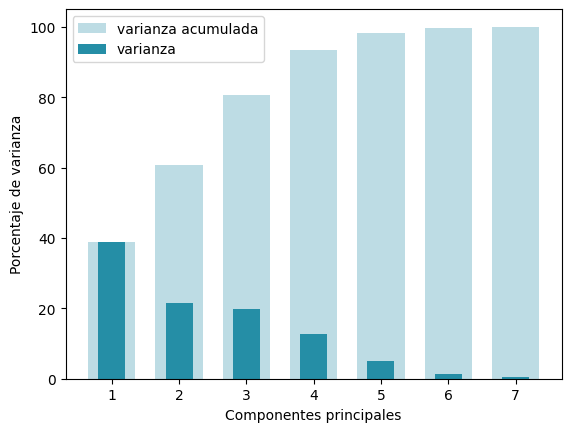

In [ ]:
# Gráfico de barras de la varianza acumulada
plt.bar(range(1, len(numeric_columns)+1), eigdf['Varianza_ac'], width=0.7,
        alpha=0.3, align='center', label='varianza acumulada', color='#258EA6')
# Se añade sobre el gráfico la varianza no acumulada con un ancho menor
plt.bar(range(1, len(numeric_columns)+1), eigdf['Varianza'], width=0.4,
        align='center', label='varianza', color='#258EA6')

plt.ylabel('Porcentaje de varianza')
plt.xlabel('Componentes principales')
# Se coloca la leyenda en la posición más adecuada en función del trazado de la
# gráfica
plt.legend(loc = 'best')
plt.show()

En el caso presente, se persigue el análisis de las relaciones entre los indicadores de estudio así como sus consecuencias en los históricos de las ciudades. Por lo tanto, se prioriza la elección de componentes principales que permitan una representación sencilla de los individuos o poblaciones en el espacio. Este es el caso de los trazados tanto en dos como en tres dimensiones, fácilmente comprensibles para el criterio humano. Luego se considerará la información expresada por las dos y tres primeras componentes, y se evaluará el porcentaje incluido en estas dos alternativas.

In [ ]:
# Con dos componentes
lost_info = 100 - eigdf['Varianza_ac'].iloc[1:3]
repr_info = eigdf['Varianza_ac'].iloc[1:3]

info = pd.DataFrame({
    'Info_repr': repr_info,
    'Info_perd': lost_info})
print(info)

   Info_repr  Info_perd
1  60.577922  39.422078
2  80.506108  19.493892


En concreto, se puede ver que el empleo de dos componentes pierde un 39.422% mientras que la elección de tres componentes para el análisis representa un 80.506% de la información.

**3.- Por último queremos representar gráficamente las ciudades de nuestro dataset, pero usando los valores de las componentes principales obtenidas. Obtén un diagrama de dispersión en 3 dimensiones y comenta qué has interpretado en él. Es necesario que el diagrama contenga toda la información necesaria. Habrá que interpretar qué información proporciona el eje X, Y y el Z. Por último, elegir al menos 4 ciudades de forma aleatoria y explicar qué pasa con ellas.**

**Explicación de la información representada por las componentes**

De acuerdo a lo observado previamente, se considera que el tratamiento de la información a través de las tres primeras componentes puede resultar suficiente para sacar conclusiones fiables, con un 80.506%. Una vez se han obtenido las componentes princicipales con las que se va a proceder al análisis de las ciudades de estudio, se analizará la información contenida en cada una de estas para contribuir a la explicación de la posición de los individuos con respecto a los ejes.

In [ ]:
# Calcular la proporción de varianza explicada por cada componente
for i in range(3):
  loadings_df = pd.DataFrame({'Variable': numeric_columns,
                              'Loading': eigenvectors[:, i]})
  print(f"Información de la CP{i+1}:")
  print(loadings_df)
  print()

Información de la CP1:
    Variable   Loading
0        SO2  0.489699
1   Neg.Temp -0.315371
2   Empresas  0.541169
3  Poblacion  0.487588
4     Viento  0.249875
5     Precip  0.000187
6       Dias  0.260179

Información de la CP2:
    Variable   Loading
0        SO2  0.084576
1   Neg.Temp -0.088638
2   Empresas -0.225881
3  Poblacion -0.282004
4     Viento  0.055471
5     Precip  0.625879
6       Dias  0.677967

Información de la CP3:
    Variable   Loading
0        SO2 -0.014350
1   Neg.Temp -0.677136
2   Empresas -0.267159
3  Poblacion -0.344838
4     Viento  0.311265
5     Precip -0.492036
6       Dias  0.109579



1. Los valores más altos positivos se corresponden con las variables de *SO2*, *Empresas* y *Poblacion*. Núcleos poblaciones con mayor concentración de empresas, mayor demanda de infraestructuras industriales y, como consecuencia, niveles más altos de dióxido de azufre (SO2).

2. La información más relevante viene dada por las variables *Precip* y *Dias*. Esta componente mide las ciudades en función de cuán lluvioso sea su clima.

3. Temperaturas muy bajas en un clima relativamente seco donde las ráfagas de viento son bastante comunes. Estas poblaciones no destacan especialmente por su actividad económica o densidad demográfica.

Ya conocidas las componentes con las que se va a trabajar, se estudiarán los individuos en función de estas tres. Para ello, se computan las posiciones que ocupan en el espacio tridimensional a través del producto escalar de las filas del DataFrame estandarizado con los autovectores propios de las componentes. El resultado de cada fila resume la información contenida en el DataFrame original en función de la explicación de cada componente; indica tanto la intensidad como la dirección que el individuo toma.

In [ ]:
# Información representada por los tres componentes principales
W = eigenvectors[:, :3]
data_pca = df[numeric_columns].dot(W)

df_pca = pd.DataFrame(data=data_pca)
df_pca.columns = ['PC1', 'PC2', 'PC3']
df_pca.head()

,PC1,PC2,PC3
0,-2.715976,-3.891439,-1.058355
1,-1.717745,0.482420,-0.850043
2,-0.938965,-2.237246,0.183748
3,-0.549861,-1.971943,1.228596
4,0.460372,1.097335,0.589704


#### Representación gráfica

**Diagrama de dispersión**

La visualización espacial de los datos resulta de gran utilidad para comprender mejor cómo estos se relacionan con las componentes principales en función de sus distancia a los ejes. Además, permite una observación bastante intuitiva sobre la variabilidad de estos y la identificación de los casos más atípicos. Para ello, se recurre al diagrama de dispersión. Esta representación en tres dimensiones ayuda a identificar patrones o agrupaciones en el espacio. Asimismo, al tratarse de una base de datos no muy extensa, la visualización resulta sencilla y contribuye de manera significativa al análisis inicial.

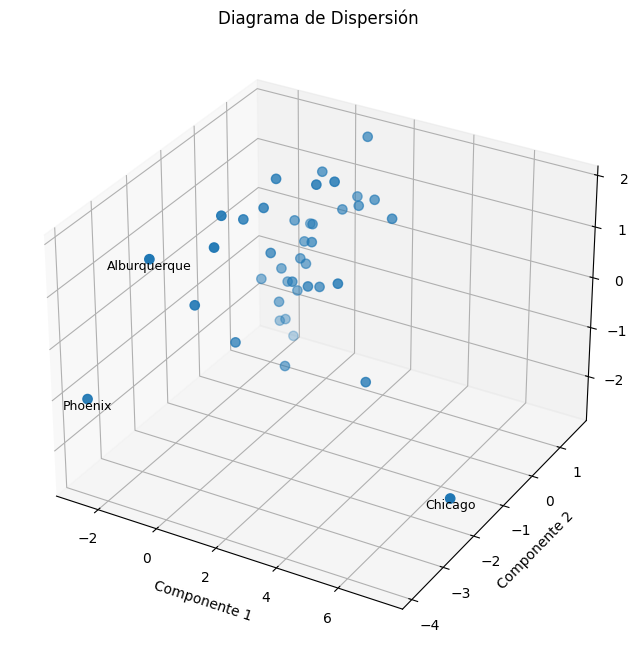

In [ ]:
# Crea un diagrama de dispersión tridimensional
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'], s=45)

# Calcular el rango intercuartílico (IQR)
Q1 = df_pca.quantile(0.25)
Q3 = df_pca.quantile(0.75)
IQR = Q3 - Q1

# Definir un umbral para identificar outliers
umbral_outliers = 1.5

# Identificar índices de outliers
outlier_indices = df_pca[(df_pca < (Q1 - umbral_outliers * IQR)) |
(df_pca > (Q3 + umbral_outliers * IQR))].any(axis=1)

# Para todos los individuos que se hayan identificado como outliers (True)
for i in df_pca.index[outlier_indices]:
    ax.text(df_pca.loc[i, 'PC1'], df_pca.loc[i, 'PC2'],
            df_pca.loc[i, 'PC3'], df.loc[i, 'Ciudad'],
            fontsize=9, va='top', ha='center')

ax.set_title('Diagrama de Dispersión')
ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.set_zlabel('Componente 3')

plt.show()

Como se ha mencionado en el párrafo anterior, se logra identificar una zona del diagrama en la que se localizan la mayor parte de los individuos o ciudades de estudio. Asimismo, la cantidad de datos más alejados de este núcleo, caracterizados como *outliers*, parece corresponderse con los datos atípicos que se observaban en los diagramas de caja, al comienzo del análisis estadístico (Chicago, Phoenix y Alburquerque). Esto quiere decir que el Análisis de Componentes Principales (PCA) logra con éxito reducir la dimensionalidad del espacio de características a la vez que mantiene inalterada la información original de los datos de estudio.

#### Elección de cinco ciudades aleatoriamente

A continuación, con el fin de analizar en mayor profundidad el impacto de la representación gráfica sobre el análisis de datos y conocer con precisión el significado de la posición con respecto a las componentes principales, se seleccionan cinco ciudades aleatoriamente para un estudio más exhaustivo de sus características. Asimismo, se imprimen los valores de los indicadores originales para cada una de las ciudades con el fin de justificar las conclusiones.

In [ ]:
random.seed(124)

# Genera un array de cinco números enteros aleatorios sin repetición que se
# encuentren en el rango de filas del DataFrame
num = 5
numeros_aleatorios = random.sample(range(0, df.shape[0]), num)
print(numeros_aleatorios)

[17, 35, 0, 11, 3]


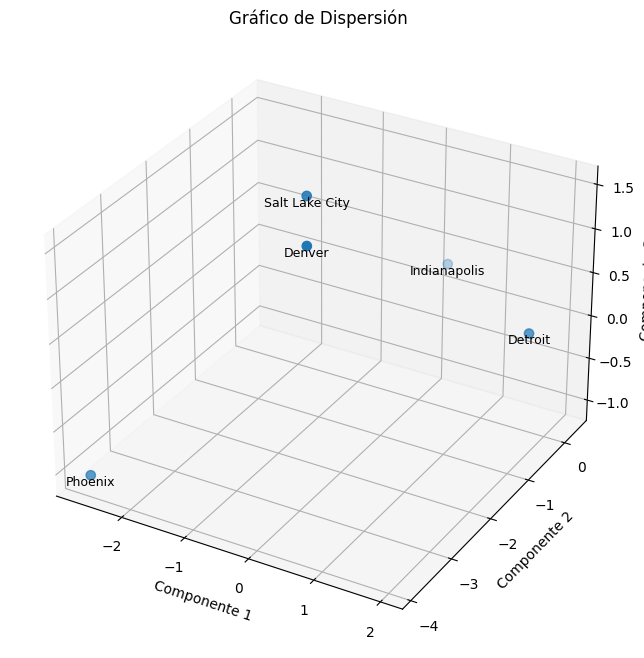

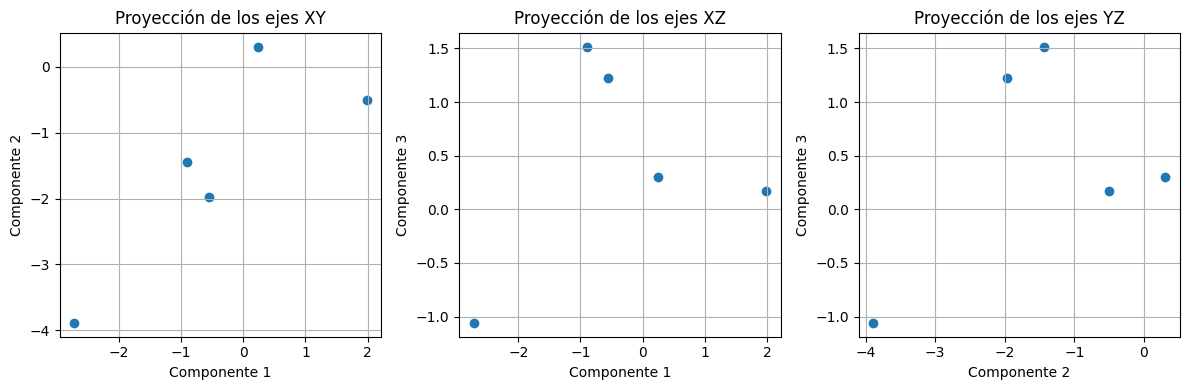

In [ ]:
# Crea un diagrama de dispersión tridimensional
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_pca['PC1'][numeros_aleatorios], df_pca['PC2'][numeros_aleatorios],
           df_pca['PC3'][numeros_aleatorios], s=45)

# Se añaden como etiquetas los nombres de las ciudades que se representan
for i in range(num):
    ax.text(df_pca['PC1'][numeros_aleatorios[i]],
            df_pca['PC2'][numeros_aleatorios[i]],
            df_pca['PC3'][numeros_aleatorios[i]],
            df['Ciudad'][numeros_aleatorios[i]],
            fontsize=9, va='top', ha='center')

ax.set_title('Gráfico de Dispersión')
ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.set_zlabel('Componente 3')

plt.show()

# Fila de gráficos para las vistas XY, XZ e YZ del diagrama
fig, (ax_xy, ax_xz, ax_yz) = plt.subplots(1, 3, figsize=(12, 4))

# Vista XY
ax_xy.scatter(df_pca['PC1'][numeros_aleatorios], df_pca['PC2'][numeros_aleatorios])
ax_xy.set_title('Proyección de los ejes XY')
ax_xy.set_xlabel('Componente 1')
ax_xy.set_ylabel('Componente 2')
ax_xy.grid(True)

# Vista XZ
ax_xz.scatter(df_pca['PC1'][numeros_aleatorios], df_pca['PC3'][numeros_aleatorios])
ax_xz.set_title('Proyección de los ejes XZ')
ax_xz.set_xlabel('Componente 1')
ax_xz.set_ylabel('Componente 3')
ax_xz.grid(True)

# Vista YZ
ax_yz.scatter(df_pca['PC2'][numeros_aleatorios], df_pca['PC3'][numeros_aleatorios])
ax_yz.set_title('Proyección de los ejes YZ')
ax_yz.set_xlabel('Componente 2')
ax_yz.set_ylabel('Componente 3')
ax_yz.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Se concatena el DataFrame de componentes con la columna 'Ciudad'
ciudades = pd.concat([df['Ciudad'][numeros_aleatorios],
                      df_pca.iloc[numeros_aleatorios]], axis=1)

print(ciudades)

            Ciudad       PC1       PC2       PC3
17         Detroit  1.984921 -0.494837  0.173157
35  Salt Lake City -0.898238 -1.439462  1.516122
0          Phoenix -2.715976 -3.891439 -1.058355
11    Indianapolis  0.243477  0.309186  0.298744
3           Denver -0.549861 -1.971943  1.228596


In [ ]:
# Filas del DataFrame original
print(df_original.iloc[numeros_aleatorios])

            Ciudad   SO2  Neg.Temp  Empresas  Poblacion  Viento  Precip   Dias
17         Detroit  35.0      49.9    1064.0     1513.0    10.1   30.96  129.0
35  Salt Lake City  28.0      51.0     137.0      176.0     8.7   15.17   89.0
0          Phoenix  10.0      70.3     213.0      582.0     6.0    7.05   36.0
11    Indianapolis  28.0      52.3     361.0      746.0     9.7   38.74  121.0
3           Denver  17.0      51.9     454.0      515.0     9.0   12.95   86.0


El individuo o población más destacado es el de Phoenix, con el valor más negativo en la segunda componente. Por lo tanto, se puede concluir que la capital de Arizona presenta el clima más seco, con valores estadísticos para las precipitaciones muy bajos y una media de 36 días de lluvia al año. Asimismo, de acuerdo a su posición con respecto al eje de la primera componente, a pesar de que Phoenix se caracteriza por una población relativamente alta (582 mil habitantes), la presencia empresarial no supone una amenaza importante para la calidad del aire y la producción de dióxido de azufre (SO2), desplazándolo notablemente hacia los valores más negativos de la primera componente.

Al igual que Phoenix no sobresale en el ámbito empresarial, resalta la situación de Detroit. Se observa que su posición con respecto a la primera componente indica que Detroit tiene una densidad demográfica bastante notable, con un total de un millón y medio de habitantes. Además, su situación es fuerte indicador de su destacada actividad empresarial, que contribuye a los niveles de gas de dióxido de azufre liberados a la atmósfera. Por otro lado, la situación de Detroit de acuerdo a la tercera componente lo posiciona como una de las ciudades más frías (49.9 °F).

En cuanto a la información representada por la tercera componente, Salt Lake City parece ser la ciudad más relevante, indicando un clima frío donde la presencia de viento suele ser mucho más frecuente. Además, es también indicador del núcleo poblacional que lo conforma (137 mil habitantes). De igual forma, Denver también destaca por esto.

En último lugar, la ciudad de Indianapolis presenta el comportamiento más promedio, con las coordenadas en las componentes principales tomando valores alrededor de más cercanos al 0. Aun así, destaca por alcanzar el valor más alto en la segunda componente, caracterizándose como la ciudad con mayor probabildad de precipitación de entre las cinco analizadas; llueve una media de 121 días al año.

**4.- Realiza los mismos pasos que en los pasos anteriores usando la librería scikit-learn. Compara los resultados y coméntalos.**

### Análisis de Componentes Principales (PCA) con la librería ***Scikit Learn***

Por último, se repetirá el mismo proceso de Análisis de Componentes Principales. En este caso, en vez de computar los cálculos desde un punto de vista más explícito, se recurrirá a una de las herramientas disponibles en la librería ***Scikit Learn***. Esta biblioteca de aprendizaje automático o Machine Learning (ML) es una de las más implementadas en python gracias a su simplicidad de manejo.

Concretamente, se implementará PCA desde el módulo *decomposition*. Esta herramienta favorece una implementación optimizada del algoritmo e incorpora toda la información necesaria para llevar a cabo el análisis de componentes a través de una sola llamada a la función. El objeto clase resultante de esta ejecución admite diferentes comandos que extraen datos como la varianza, la información representada por las componentes, etcétera. Asmismo, la herramienta admite una variedad de hiperparámetros que permiten un ajuste mayor a las necesidades y requerimientos de la tarea que se realice y los intereses propios de esta.

In [ ]:
# Llamada a la función PCA
pca = PCA()
# Aplicar PCA sobre los datos numérico estandarizados
principal_components = pca.fit_transform(df[numeric_columns])

# Se extrae la varianza de las componentes
variance = pca.explained_variance_ratio_

df_var = pd.DataFrame({
    'Varianza': variance*100,
    'Varianza_ac': np.cumsum(variance)*100
})
print(df_var)

    Varianza  Varianza_ac
0  38.973138    38.973138
1  21.604784    60.577922
2  19.928186    80.506108
3  12.742733    93.248840
4   4.953981    98.202821
5   1.432680    99.635501
6   0.364499   100.000000


No se observan diferencias entre los resultados de la librería *Scikit Learn* y el cálculo previo mediante la aplicación de la fórmula de la varianza. Se calculan los nuevos valores para las ciudades u observaciones en función de las tres componentes principales halladas.

In [ ]:
# Se extraen las coordenadas de los datos en PCA
df_pca = pd.DataFrame(principal_components[:, :3])
df_pca.columns = ['PC1', 'PC2', 'PC3']
df_pca.head()

,PC1,PC2,PC3
0,-2.715976,3.891439,1.058355
1,-1.717745,-0.482420,0.850043
2,-0.938965,2.237246,-0.183748
3,-0.549861,1.971943,-1.228596
4,0.460372,-1.097335,-0.589704


**Explicación cualitativa de las componentes principales**

Ya se había obtenido la representación de los indicadores originales en las componentes principales calculadas en la primera parte del documento. Ahora se procede a su observación, esta vez, a partir de la librería de *Scikit Learn*.

In [ ]:
for i in range(3):
  loadings = pca.components_[i]
  loadings_df = pd.DataFrame({'Variable': numeric_columns, 'Loading': loadings})
  print(f"Información de la CP{i+1}:")
  print(loadings_df)
  print()

Información de la CP1:
    Variable   Loading
0        SO2  0.489699
1   Neg.Temp -0.315371
2   Empresas  0.541169
3  Poblacion  0.487588
4     Viento  0.249875
5     Precip  0.000187
6       Dias  0.260179

Información de la CP2:
    Variable   Loading
0        SO2 -0.084576
1   Neg.Temp  0.088638
2   Empresas  0.225881
3  Poblacion  0.282004
4     Viento -0.055471
5     Precip -0.625879
6       Dias -0.677967

Información de la CP3:
    Variable   Loading
0        SO2  0.014350
1   Neg.Temp  0.677136
2   Empresas  0.267159
3  Poblacion  0.344838
4     Viento -0.311265
5     Precip  0.492036
6       Dias -0.109579



1. Los valores más altos positivos se corresponden con las variables de *SO2*, *Empresas* y *Poblacion*. Núcleos poblaciones con mayor concentración de empresas, mayor demanda de infraestructuras industriales y, como consecuencia, niveles más altos de dióxido de azufre (SO2).

2. Destacan los valores más negativos en las variables de *Precip* y *Dias*. Se trata de ciudades con los climas más secos.

3. Representa las ciudades con las temperaturas medias más altas, donde las lluvias son frecuentes y no se suelen dar días de viento. Se habla de un clima tropical relativamente húmedo.

Bien si la primera de las componentes coincide exactamente con los cálculos realizados previamente de forma analítica, se observa que el sentido de las componentes restantes se ha invertido con respecto a las obtenidas sin *Scikit Learn*. La intensidad o cantidad de información almacenada en estas componentes no ha variado. Sin embargo, los sentidos se han invertido.

#### Explicación de las variaciones en los autovectores y efectos sobre los resultados

La función **PCA** de esta librería recurre a la descomposición en valores singulares o *Singular Values Decomposition* (SVD) para el cálculo de los autovectores. En concreto, se corresponden con las columnas de la matriz $V^{T}$. Esta matriz surge de la siguiente operación sobre la matriz de covarianza después de centrar los datos:

<center>$V^{T}$ = $X^{T}$ $X$</center>

Se conoce que la computación de los autovectores en la primera parte del documento se realizaba a partir de la matriz de covarianza. Sin embargo, la librería *Scikit Learn* ejecuta PCA y emplea SVD para obtener estos mismos autovectores. Estas diferencias en los algoritmos de ejecución de cada una de las alternativas puede provocar cambios en el sentido de los vectores. Aun así, estos cambios no alteran la información correspondiente a cada ciudad, pues estas variaciones se encuentran en el sentido y no en la dirección [7].

#### Representación gráfica

Según el procedimiento del Análisis de Componentes Principales, cabría esperar que el diagrama de dispersión generado fuese idéntico al calculado en la primera parte del estudio. No obstante, como consecuencia de los hallazgos sobre la dirección de las dos últimas componentes, se observa un desplazamiento de los puntos o datos.

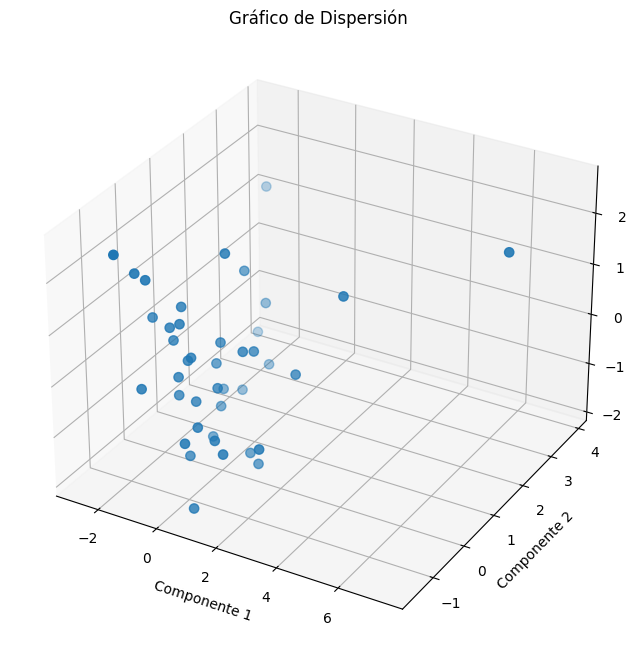

In [ ]:
# Diagrama de dispersión tridimensional
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'], s=45)

ax.set_title('Gráfico de Dispersión')
ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.set_zlabel('Componente 3')

plt.show()

El eje Y al igual que el Z se han invertido. Por lo tanto, se ha producido un giro de 180 grados en la distribución de las ciudades en la profundidad del diagrama; antes se localizaba la mayor parte al fondo de la imagen mientras que ahora se encuentran al frente del diagrama. Además, su posición se ha revertido en el eje vertical. A pesar de estas alteraciones en la visualización de los datos, se sigue conservando el significado de sus indicadores.

#### Elección de cinco ciudades aletoriamente

Se volverá a realizar el estudio de las cinco ciudades vistas anteriormente. Para ello, se representarán en el diagrama de dispersión. Conociendo que ya se han analizado las características de las poblaciones, en esta ocasión se pondrá el enfoque en las diferencias en el espacio del diagrama en comparación con el previo y lo que ello implica.

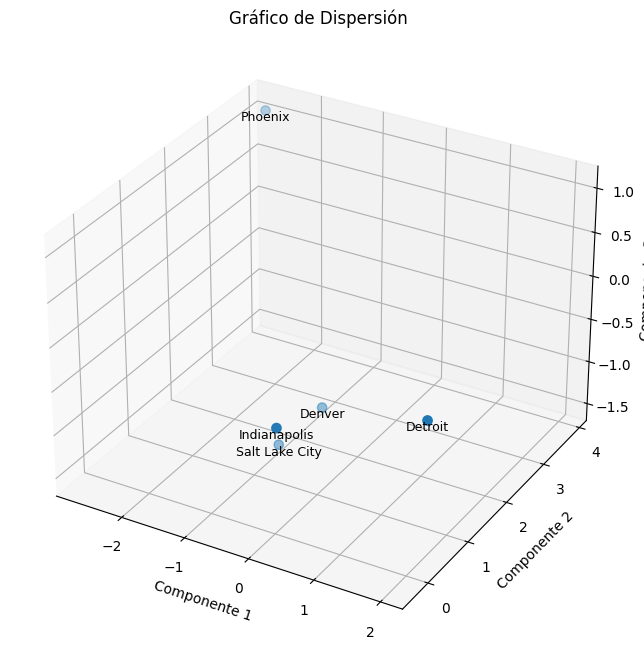

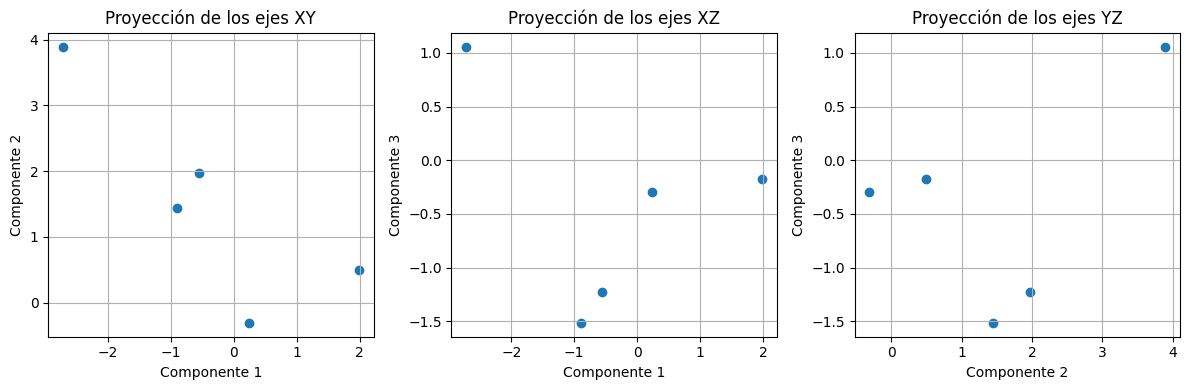

In [ ]:
# Crea un diagrama de dispersión tridimensional
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_pca['PC1'][numeros_aleatorios], df_pca['PC2'][numeros_aleatorios],
           df_pca['PC3'][numeros_aleatorios], s=45)

# Etiquetas de los individuos en el diagrama
for i in range(num):
    ax.text(df_pca['PC1'][numeros_aleatorios[i]],
            df_pca['PC2'][numeros_aleatorios[i]],
            df_pca['PC3'][numeros_aleatorios[i]],
            df['Ciudad'][numeros_aleatorios[i]],
            fontsize=9, va='top', ha='center')

ax.set_title('Gráfico de Dispersión')
ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.set_zlabel('Componente 3')

plt.show()

# Fila de gráficos para las vistas XY, XZ e YZ del diagrama
fig, (ax_xy, ax_xz, ax_yz) = plt.subplots(1, 3, figsize=(12, 4))

# Vista XY
ax_xy.scatter(df_pca['PC1'][numeros_aleatorios], df_pca['PC2'][numeros_aleatorios])
ax_xy.set_title('Proyección de los ejes XY')
ax_xy.set_xlabel('Componente 1')
ax_xy.set_ylabel('Componente 2')
ax_xy.grid(True)

# Vista XZ
ax_xz.scatter(df_pca['PC1'][numeros_aleatorios], df_pca['PC3'][numeros_aleatorios])
ax_xz.set_title('Proyección de los ejes XZ')
ax_xz.set_xlabel('Componente 1')
ax_xz.set_ylabel('Componente 3')
ax_xz.grid(True)

# Vista YZ
ax_yz.scatter(df_pca['PC2'][numeros_aleatorios], df_pca['PC3'][numeros_aleatorios])
ax_yz.set_title('Proyección de los ejes YZ')
ax_yz.set_xlabel('Componente 2')
ax_yz.set_ylabel('Componente 3')
ax_yz.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Coordenadas de las ciudades de estudio
ciudades = pd.concat([df['Ciudad'][numeros_aleatorios],
                      df_pca.iloc[numeros_aleatorios]], axis=1)
print(ciudades)

            Ciudad       PC1       PC2       PC3
17         Detroit  1.984921  0.494837 -0.173157
35  Salt Lake City -0.898238  1.439462 -1.516122
0          Phoenix -2.715976  3.891439  1.058355
11    Indianapolis  0.243477 -0.309186 -0.298744
3           Denver -0.549861  1.971943 -1.228596


La información que se conoce de estas ciudades, como ya se ha justificado, coincide con los datos descriptivos de cada una de ellas que se especificaban al comienzo del documento en la base de datos original. Por lo tanto, a pesar de la variabilidad que se ha apreciado en el sentido de la segunda y tercera componente, no se ha alterado la precisión de su representatividad.

Por ejemplo, la ciudad de Phoenix presenta un valor muy alto en la segunda componente. Del mismo modo que esta componente resumía esta vez situaciones de climas más secos, se sigue afirmando que Phoenix se caracteriza por ser una de las ciudades con menor cantidad y frecuencia de precipitación. Asimismo, Phoenix presenta el valor más positivo de las cinco poblaciones en la tercera componente, indicando un clima cálido en el que las lluvias son relativamente frecuentes. A pesar de la contradicción que se genera con la información expresada en la segunda componente, se han de tener en cuenta los valores en PC2 y PC3. La segunda componente, cuya información se centra principalmente entorno a las precipitaciones, adquiere un valor de 3.891 en Phoenix, mientras que la tercera componente se reduce a un tercio de este. Como la tercera componente se orienta alrededor de la temperatura media como indicador más significativo, se puede concluir que Phoenix adquiere un valor relativamente alto en esta debido a sus altas temperaturas (70.3 °F) a pesar de la escasez de precipitaciones.

Por otra parte, como la primera componente generada coincide con la computada en la primera parte, el valor alto de esta para la ciudad de Detroit sigue respaldando su alta densidad demográfica, actividad empresarial y, por consecuencia, niveles de contaminación por dióxido de azufre (SO2).

## Bibliografía

[1]: “El clima en Hamburgo, el tiempo por mes, temperatura promedio (Alemania) - Weather Spark,” Weather Spark. https://es.weatherspark.com/y/68301/Clima-promedio-en-Hamburgo-Alemania-durante-todo-el-a%C3%B1o

[2]: “IQAIR | First in air quality.” https://www.iqair.com/es/newsroom/wind-weather-air-pollution

[3]: colaboradores de Wikipedia, “Escala de Beaufort,” Wikipedia, La Enciclopedia Libre, Jan. 29, 2024. https://es.wikipedia.org/wiki/Escala_de_Beaufort#Escala_meteorol%C3%B3gica

[4]: L. Vanguardia, “Los 4 colores de la niebla de la DGT para avisar del nivel visibilidad en la carretera,” La Vanguardia, Jan. 03, 2024. [Online]. Available: https://www.lavanguardia.com/motor/dgt/20240103/9451000/colores-niebla-dgt-avisar-nivel-visibilidad-carreteras-tsc.html

[5]: O. Style, “La humedad y la calidad del aire ¿cuál es su nivel óptimo? ¿cómo medirla?,” caloryfrio.com, Jun. 03, 2020. https://www.caloryfrio.com/construccion-sostenible/ventilacion-y-calidad-aire-interior/humedad-y-calidad-del-aire-cual-es-nivel-optimo-como-medirla.html

[6]: “Review of the Primary National Ambient Air Quality Standards for Sulfur Oxides,” Federal Register, Mar. 18, 2019. https://www.federalregister.gov/documents/2019/03/18/2019-03855/review-of-the-primary-national-ambient-air-quality-standards-for-sulfur-oxides

[7]: “Sklearn.decomposition.PCA,” Scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
